root
 |-- NUM_POSTE: decimal(8,0) (nullable = true)
 |-- NOM_USUEL: string (nullable = true)
 |-- LAT: double (nullable = true)
 |-- LON: double (nullable = true)
 |-- ALTI: integer (nullable = true)
 |-- AAAAMMJJ: integer (nullable = true)
 |-- RR: double (nullable = true)
 |-- QRR: integer (nullable = true)
 |-- TN: double (nullable = true)
 |-- QTN: integer (nullable = true)
 |-- HTN: integer (nullable = true)
 |-- QHTN: integer (nullable = true)
 |-- TX: double (nullable = true)
 |-- QTX: integer (nullable = true)
 |-- HTX: integer (nullable = true)
 |-- QHTX: integer (nullable = true)
 |-- TM: double (nullable = true)
 |-- QTM: integer (nullable = true)
 |-- TNTXM: double (nullable = true)
 |-- QTNTXM: integer (nullable = true)
 |-- TAMPLI: double (nullable = true)
 |-- QTAMPLI: integer (nullable = true)
 |-- TNSOL: double (nullable = true)
 |-- QTNSOL: integer (nullable = true)
 |-- TN50: double (nullable = true)
 |-- QTN50: integer (nullable = true)
 |-- DG: integer (nullable = 

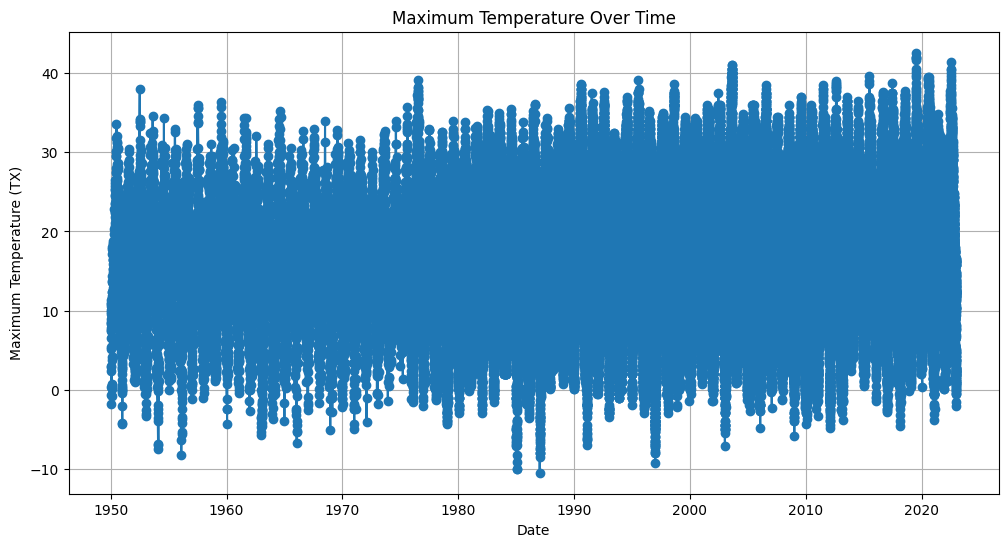

In [3]:
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt
import os

# Initialize Spark session
spark = SparkSession.builder \
    .appName("Partitioned Data Plotting") \
    .getOrCreate()

# Path to the directory containing the partitioned CSV files
data_dir = "./all_weather"  # Adjust this path as needed

# Read all partitioned CSV files into a single DataFrame
df = spark.read.csv(os.path.join(data_dir, "part-*"), header=True, inferSchema=True)

# Show the schema and a sample of the DataFrame
df.printSchema()
df.show(5)

# Convert to Pandas DataFrame for plotting
pandas_df = df.toPandas()

# Convert the date column to a datetime format
pandas_df['AAAAMMJJ'] = pd.to_datetime(pandas_df['AAAAMMJJ'], format='%Y%m%d')

# Plotting temperature over time
plt.figure(figsize=(12, 6))
plt.plot(pandas_df['AAAAMMJJ'], pandas_df['TX'], marker='o', linestyle='-')
plt.title("Maximum Temperature Over Time")
plt.xlabel("Date")
plt.ylabel("Maximum Temperature (TX)")
plt.grid(True)
plt.show()

# Close the Spark session
spark.stop()


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Chargement des datasets
weather_df = pd.read_csv('path/to/2023-2024-weather_cleaned.csv')
traffic_df = pd.read_csv('path/to/2013-2021_trafic.csv')
validations_df = pd.read_csv('path/to/validations-reseau-ferre-nombre-validations-par-jour-1er-semestre.csv')
chantier_df = pd.read_csv('path/to/chantier2019-2022.csv')

# 2. Prétraitement des données

# Renommer les colonnes pour simplifier les jointures
weather_df.rename(columns={'NUM_POSTE': 'station_id', 'AAAAMMJJ': 'date'}, inplace=True)
traffic_df.rename(columns={'Station': 'station_name', 'Trafic': 'traffic'}, inplace=True)
validations_df.rename(columns={'CODE_STIF_ARRET': 'station_id', 'JOUR': 'date'}, inplace=True)
chantier_df.rename(columns={'Date début du chantier': 'start_date', 'Date fin du chantier': 'end_date'}, inplace=True)

# Convertir les dates en format datetime
weather_df['date'] = pd.to_datetime(weather_df['date'], format='%Y%m%d')
validations_df['date'] = pd.to_datetime(validations_df['date'], format='%Y-%m-%d')
chantier_df['start_date'] = pd.to_datetime(chantier_df['start_date'])
chantier_df['end_date'] = pd.to_datetime(chantier_df['end_date'])

# Fusionner les datasets sur les stations et les dates
merged_df = pd.merge(weather_df, validations_df, on=['station_id', 'date'], how='left')
merged_df = pd.merge(merged_df, traffic_df, left_on='station_id', right_on='Station', how='left')

# Créer une colonne binaire pour indiquer si un chantier a lieu sur une station à une date donnée
def is_chantier(row, chantier_df):
    for _, chantier in chantier_df.iterrows():
        if chantier['start_date'] <= row['date'] <= chantier['end_date']:
            return 1
    return 0

merged_df['chantier'] = merged_df.apply(lambda row: is_chantier(row, chantier_df), axis=1)

# 3. Séparation des données en ensembles d'entraînement et de test
X = merged_df.drop(columns=['chantier', 'date', 'station_name'])
y = merged_df['chantier']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Création et entraînement du modèle
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 5. Évaluation du modèle
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# 6. Visualisation des résultats
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.show()

# Heatmap des corrélations
corr_matrix = merged_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


ModuleNotFoundError: No module named 'sklearn'

In [1]:
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Chargement des datasets
print("Chargement des datasets...")
weather_df = pd.read_csv('./all_weather/2023-2024-weather_cleaned.csv')
traffic_df = pd.read_csv('./freq_arret/2013-2021_trafic.csv')
validations_df = pd.read_csv('./freq_arret/validations-reseau-ferre-nombre-validations-par-jour-1er-semestre.csv', sep=';')
chantier_df = pd.read_csv('chantier2019-2022.csv')
print("Datasets chargés.")

# Chargement du JSON des voies ferrées
print("Chargement du JSON des voies ferrées...")
with open(r'C:\Users\SKONIECZNY\Desktop\Transport_App\client\src\common\traces-du-reseau-ferre-idf.json', 'r') as file:
    voie_data = json.load(file)
print("JSON des voies ferrées chargé.")

# Extraire les informations du JSON des voies ferrées
print("Extraction des informations du JSON des voies ferrées...")
voies_list = []
for feature in voie_data['features']:
    properties = feature['properties']
    coordinates = feature['geometry']['coordinates']
    voie = {
        'idrefliga': properties['idrefliga'],
        'reseau': properties['reseau'],
        'mode': properties['mode'],
        'coordinates': coordinates
    }
    voies_list.append(voie)
voies_df = pd.DataFrame(voies_list)
print("Informations des voies ferrées extraites.")

# 2. Prétraitement des données
print("Prétraitement des données...")

# Renommer les colonnes pour simplifier les jointures
print("Renommage des colonnes...")
weather_df.rename(columns={'NUM_POSTE': 'station_id', 'AAAAMMJJ': 'date'}, inplace=True)
traffic_df.rename(columns={'Station': 'station_name', 'Trafic': 'traffic'}, inplace=True)
validations_df.rename(columns={'CODE_STIF_ARRET': 'station_id', 'JOUR': 'date'}, inplace=True)
chantier_df.rename(columns={'Date début du chantier': 'start_date', 'Date fin du chantier': 'end_date'}, inplace=True)
print("Colonnes renommées.")

# Vérifier les colonnes
print("Colonnes de weather_df:", weather_df.columns)
print("Colonnes de traffic_df:", traffic_df.columns)
print("Colonnes de validations_df:", validations_df.columns)
print("Colonnes de chantier_df:", chantier_df.columns)

# Convertir 'station_id' en string pour les deux dataframes avant la fusion
print("Conversion des types de données...")
weather_df['station_id'] = weather_df['station_id'].astype(str)
validations_df['station_id'] = validations_df['station_id'].astype(str)

# Convertir les dates en format datetime
weather_df['date'] = pd.to_datetime(weather_df['date'], format='%Y%m%d')
validations_df['date'] = pd.to_datetime(validations_df['date'], format='%Y-%m-%d')
chantier_df['start_date'] = pd.to_datetime(chantier_df['start_date'])
chantier_df['end_date'] = pd.to_datetime(chantier_df['end_date'])
print("Types de données convertis.")

# Fusionner les datasets sur les stations et les dates
print("Fusion des datasets...")
merged_df = pd.merge(weather_df, validations_df, on=['station_id', 'date'], how='left')
merged_df = pd.merge(merged_df, traffic_df, left_on='station_id', right_on='station_name', how='left')
print("Datasets fusionnés.")

# Joindre les données de voies
print("Ajout des informations des voies...")
def match_voie(station_id, voies_df):
    for _, voie in voies_df.iterrows():
        if station_id in voie['coordinates']:
            return voie['reseau'], voie['mode']
    return None, None

merged_df[['reseau', 'mode']] = merged_df['station_id'].apply(lambda x: match_voie(x, voies_df)).apply(pd.Series)
print("Informations des voies ajoutées.")

# Créer une colonne binaire pour indiquer si un chantier a lieu sur une station à une date donnée
print("Création de la colonne 'chantier'...")
def is_chantier(row, chantier_df):
    for _, chantier in chantier_df.iterrows():
        if chantier['start_date'] <= row['date'] <= chantier['end_date']:
            return 1
    return 0

merged_df['chantier'] = merged_df.apply(lambda row: is_chantier(row, chantier_df), axis=1)
print("Colonne 'chantier' créée.")

# 3. Séparation des données en ensembles d'entraînement et de test
print("Séparation des données en ensembles d'entraînement et de test...")
columns_to_drop = ['chantier', 'date', 'station_name']
if 'coordinates' in merged_df.columns:
    columns_to_drop.append('coordinates')

X = merged_df.drop(columns=columns_to_drop)
y = merged_df['chantier']

# Sélection des colonnes numériques et catégorielles
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Pipeline pour les colonnes numériques
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Pipeline pour les colonnes catégorielles
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combiner les transformations dans un ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Pipeline complet avec prétraitement et modèle
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Données séparées.")

# 4. Création et entraînement du modèle
print("Création et entraînement du modèle...")
model.fit(X_train, y_train)
print("Modèle créé et entraîné.")

# 5. Évaluation du modèle
print("Évaluation du modèle...")
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Évaluation du modèle terminée.")

# 6. Visualisation des résultats
print("Visualisation des résultats...")
# Extraire l'importance des features
importances = model.named_steps['classifier'].feature_importances_

# Récupérer les noms des features après OneHotEncoding
encoder = model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder']
encoded_cat_features = encoder.get_feature_names_out(categorical_features)

# Combiner les noms des features
feature_names = np.hstack([numeric_features, encoded_cat_features])

# Visualiser l'importance des features
feature_importances = pd.Series(importances, index=feature_names)
feature_importances.nlargest(10).plot(kind='barh')
plt.show()

# Heatmap des corrélations
print("Visualisation des corrélations...")
corr_matrix = merged_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

# Exemple de retour des coordonnées et de la probabilité pour une voie donnée
print("Exemple de prédiction avec probabilité pour une voie donnée...")
example_station_id = merged_df.iloc[0]['station_id']
example_row = merged_df[merged_df['station_id'] == example_station_id].drop(columns=columns_to_drop + ['chantier']).iloc[0]
example_prediction = model.predict([example_row])[0]
example_proba = model.predict_proba([example_row])[0]

print(f"Station ID: {example_station_id}")
print(f"Coordonnées: {merged_df[merged_df['station_id'] == example_station_id]['coordinates'].values[0]}")
print(f"Prédiction: {'Chantier' if example_prediction == 1 else 'Pas de chantier'}")
print(f"Probabilités: {example_proba}")


ModuleNotFoundError: No module named 'sklearn'

In [4]:
!pip install pandas
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn
!pip install numpy


     ---------------------------------------- 0.0/60.6 kB ? eta -:--:--
     ---------------------------------------- 60.6/60.6 kB 3.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
   -------- ------------------------------- 2.2/10.6 MB 46.2 MB/s eta 0:00:01
   ------------------- -------------------- 5.0/10.6 MB 53.5 MB/s eta 0:00:01
   ----------------------------- ---------- 7.8/10.6 MB 55.2 MB/s eta 0:00:01
   ---------------------------------------  10.6/10.6 MB 59.5 MB/s eta 0:00:01
   ---------------------------------------  10.6/10.6 MB 59.5 MB/s eta 0:00:01
   ---------------------------------------- 10.6/10.6 MB 46.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/301.8 kB ? eta -:--:--
   --------------------------------------- 301.8/301.8 kB 18.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/46.2 MB ? eta -:--:--
   -- ------------------------------------- 2.9/46.2 MB 60.8 MB/s eta 0:00:01
   ---- 

In [13]:
import pandas as pd
import json
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function to convert dates with different formats
def parse_dates(date_str):
    try:
        return pd.to_datetime(date_str, format='%d/%m/%Y', errors='raise')
    except ValueError:
        try:
            return pd.to_datetime(date_str, format='%Y-%m-%d', errors='raise')
        except ValueError:
            if isinstance(date_str, str) and 'S' in date_str:
                year = int(date_str[:4])
                semester = int(date_str[-1])
                month = 1 if semester == 1 else 7
                return pd.Timestamp(year=year, month=month, day=1)
            else:
                return pd.NaT

# Function to load JSON data
def load_json(file_path):
    with open(file_path, 'r') as file:
        return json.load(file)

# Function to read large CSV files in smaller chunks
def read_csv_in_chunks(file_path, chunk_size=10000):
    reader = pd.read_csv(file_path, dtype={'1': str, '2': str, '4': str}, chunksize=chunk_size, on_bad_lines='skip')
    chunks = []
    for chunk in reader:
        chunks.append(chunk)
    return pd.concat(chunks, ignore_index=True)

# Function to load all CSV files from a directory
def load_all_csv_from_dir(directory, chunk_size=10000):
    all_data = []
    for file in os.listdir(directory):
        if file.endswith('.csv'):
            print(f"Loading {file}...")
            try:
                data = read_csv_in_chunks(os.path.join(directory, file), chunk_size=chunk_size)
                all_data.append(data)
            except Exception as e:
                print(f"Error loading {file}: {e}")
    return pd.concat(all_data, ignore_index=True)

# Load datasets
print("Loading datasets...")
weather_df = pd.read_csv('./all_weather/2023-2024-weather_cleaned.csv')
traffic_df = pd.read_csv('./freq_arret/2013-2021_trafic.csv')
validations_df = pd.read_csv('./freq_arret/validations-reseau-ferre-nombre-validations-par-jour-1er-semestre.csv', sep=';')
chantier_df = pd.read_csv('chantier2019-2022.csv')

print("Chargement du JSON des voies ferrées...")
with open(r'C:\Users\SKONIECZNY\Desktop\Transport_App\client\src\common\traces-du-reseau-ferre-idf.json', 'r') as file:
    voie_data = json.load(file)
print("JSON des voies ferrées chargé.")

# Extraire les informations du JSON des voies ferrées
print("Extraction des informations du JSON des voies ferrées...")
voies_list = []
for feature in voie_data['features']:
    properties = feature['properties']
    coordinates = feature['geometry']['coordinates']
    voie = {
        'idrefliga': properties['idrefliga'],
        'reseau': properties['reseau'],
        'mode': properties['mode'],
        'coordinates': coordinates
    }
    voies_list.append(voie)
voies_df = pd.DataFrame(voies_list)
print("Informations des voies ferrées extraites.")

# Load additional CSV files from directories
print("Loading additional datasets...")
merged_nb_fer_df = load_all_csv_from_dir('./validation/merged_NB_FER.csv/')
merged_profil_df = load_all_csv_from_dir('./validation/merged_PROFIL.csv/')

# Load JSON files for line reports
print("Loading line report JSON data...")
line_report_files = [f'./line-report/{file}' for file in os.listdir('./line-report') if file.endswith('.json')]
line_reports = [load_json(file) for file in line_report_files]

# Load additional CSV files
print("Loading specific additional CSV files...")
additional_csv_files = [
    './freq_arret/arrets.csv',
    './freq_arret/validations-reseau-ferre-nombre-validations-par-jour-1er-semestre.csv',
    './freq_arret/validations-reseau-ferre-profils-horaires-par-jour-type-1er-semestre.csv',
    './indicateurs-qualite-service-sncf-ratp.csv',
    './TravauxSNCF_RATP_2019-2022.csv',
]

additional_dfs = [read_csv_in_chunks(file) for file in additional_csv_files]

# Combine all additional CSV dataframes
additional_df = pd.concat(additional_dfs, ignore_index=True)

print("Datasets loaded.")

# Preprocess data
print("Preprocessing data...")

# Rename columns for easier merging
print("Renaming columns...")
weather_df.rename(columns={'NUM_POSTE': 'station_id', 'AAAAMMJJ': 'date'}, inplace=True)
traffic_df.rename(columns={'Station': 'station_name', 'Trafic': 'traffic'}, inplace=True)
validations_df.rename(columns={'CODE_STIF_ARRET': 'station_id', 'JOUR': 'date'}, inplace=True)
chantier_df.rename(columns={'Date début du chantier': 'start_date', 'Date fin du chantier': 'end_date'}, inplace=True)
print("Columns renamed.")

# Convert 'station_id' to string for the two dataframes before merging
print("Converting data types...")
weather_df['station_id'] = weather_df['station_id'].astype(str)
validations_df['station_id'] = validations_df['station_id'].astype(str)
merged_nb_fer_df['station_id'] = merged_nb_fer_df['CODE_STIF_ARRET'].astype(str)
merged_profil_df['station_id'] = merged_profil_df['CODE_STIF_ARRET'].astype(str)

# Convert dates to datetime format
weather_df['date'] = pd.to_datetime(weather_df['date'], format='%Y%m%d')
validations_df['date'] = pd.to_datetime(validations_df['date'], format='%Y-%m-%d')
chantier_df['start_date'] = pd.to_datetime(chantier_df['start_date'])
chantier_df['end_date'] = pd.to_datetime(chantier_df['end_date'])
merged_nb_fer_df['date'] = merged_nb_fer_df['date'].apply(parse_dates)
merged_profil_df['date'] = merged_profil_df['date'].apply(parse_dates)
print("Data types converted.")

# Merge datasets on stations and dates
print("Merging datasets...")
merged_df = pd.merge(weather_df, validations_df, on=['station_id', 'date'], how='left')
merged_df = pd.merge(merged_df, traffic_df, left_on='station_id', right_on='station_name', how='left')
merged_df = pd.merge(merged_df, merged_nb_fer_df, on=['station_id', 'date'], how='left')
merged_df = pd.merge(merged_df, merged_profil_df, on=['station_id', 'date'], how='left')




Loading datasets...
Chargement du JSON des voies ferrées...
JSON des voies ferrées chargé.
Extraction des informations du JSON des voies ferrées...
Informations des voies ferrées extraites.
Loading additional datasets...
Loading part-00000-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv...
Loading part-00001-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv...
Loading part-00002-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv...
Loading part-00003-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv...
Loading part-00004-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv...
Loading part-00005-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv...
Loading part-00006-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv...
Loading part-00007-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv...
Loading part-00008-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv...
Loading part-00009-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv...
Loading part-00010-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv...
Loading part-00011-4bea7afa-2c5

In [14]:
merged_back_up = merged_df.copy()

In [15]:
merged_df

,station_id,NOM_USUEL,LAT,LON,ALTI_x,date,PMERM,QPMERM,PMERMIN,QPMERMIN,...,CATEGORIE_TITRE_y,NB_VALD_y,CODE_STIF_TRNS,CODE_STIF_RES,CODE_STIF_ARRET_y,LIBELLE_ARRET,ID_REFA_LDA_y,CAT_JOUR,TRNC_HORR_60,pourc_validations
0,75106001,LUXEMBOURG,48.844667,2.333833,46.0,2023-01-01,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,75107005,TOUR EIFFEL,48.858333,2.294500,330.0,2023-01-01,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,75110001,LARIBOISIERE,48.882833,2.352000,55.0,2023-01-01,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,75112004,ST-ANTOINE,48.848167,2.380833,NaN,2023-01-01,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,75114001,PARIS-MONTSOURIS,48.821667,2.337833,75.0,2023-01-01,1014.9,1.0,1012.2,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2961,75107005,TOUR EIFFEL,48.858333,2.294500,330.0,2024-04-28,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2962,75110001,LARIBOISIERE,48.882833,2.352000,55.0,2024-04-28,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2963,75114001,PARIS-MONTSOURIS,48.821667,2.337833,75.0,2024-04-28,1010.8,1.0,1001.4,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2964,75114007,PARIS-MONTSOURIS-DOUBLE,48.821667,2.337833,75.0,2024-04-28,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
merged_df.columns

import pandas as pd

# Method 1: Use Pandas Options to Display All Columns
pd.set_option('display.max_columns', None)
print(merged_df.columns)

# Method 2: Convert Columns to List and Print
print(list(merged_df.columns))


Index(['station_id', 'NOM_USUEL', 'LAT', 'LON', 'ALTI_x', 'date', 'PMERM',
       'QPMERM', 'PMERMIN', 'QPMERMIN',
       ...
       'Responsable du chantier_y', 'Maîtrise d'ouvrage principale_y',
       'Surface (m2)_y', 'Synthèse - Nature du chantier_y',
       'Encombrement espace public_y', 'Impact stationnement_y',
       'Identifiant demande CITE_y', 'Identifiant Chantier CITE_y',
       'geo_shape_y', 'geo_point_2d_y'],
      dtype='object', length=157)
['station_id', 'NOM_USUEL', 'LAT', 'LON', 'ALTI_x', 'date', 'PMERM', 'QPMERM', 'PMERMIN', 'QPMERMIN', 'INST', 'QINST', 'GLOT', 'QGLOT', 'SIGMA', 'QSIGMA', 'UN', 'QUN', 'HUN', 'QHUN', 'UX', 'QUX', 'HUX', 'QHUX', 'UM', 'QUM', 'DHUMI40', 'QDHUMI40', 'DHUMI80', 'QDHUMI80', 'TSVM', 'QTSVM', 'ETPMON', 'QETPMON', 'ETPGRILLE', 'QETPGRILLE', 'NEIGETOTX', 'QNEIGETOTX', 'NEIGETOT06', 'QNEIGETOT06', 'NEIG', 'QNEIG', 'BROU', 'QBROU', 'GELEE', 'QGELEE', 'FUMEE', 'QFUMEE', 'BRUME', 'QBRUME', 'ALTI_y', 'RR', 'QRR', 'TN', 'QTN', 'HTN', 'QHTN', 'T

In [25]:
import pandas as pd

# Assuming merged_df is already defined and contains the data

# List of column pairs that provide similar information
column_pairs = [
    ('ALTI_x', 'ALTI_y'),
    ('CODE_STIF_TRNS_x', 'CODE_STIF_TRNS_y'),
    ('CODE_STIF_TRNS_x', 'CODE_STIF_TRNS'),
    ('CODE_STIF_RES_x', 'CODE_STIF_RES_y'),
    ('CODE_STIF_RES_x', 'CODE_STIF_RES'),
    ('LIBELLE_ARRET_x', 'LIBELLE_ARRET_y'),
    ('LIBELLE_ARRET_x', 'LIBELLE_ARRET'),
    ('ID_REFA_LDA_x', 'ID_REFA_LDA_y'),
    ('CATEGORIE_TITRE_x', 'CATEGORIE_TITRE_y'),
    ('NB_VALD_x', 'NB_VALD_y'),
    ('Référence Chantier_x', 'Référence Chantier_y'),
    ('start_date_x', 'start_date_y'),
    ('end_date_x', 'end_date_y'),
    ('Responsable du chantier_x', 'Responsable du chantier_y'),
    ("Maîtrise d'ouvrage principale_x", "Maîtrise d'ouvrage principale_y"),
    ('Surface (m2)_x', 'Surface (m2)_y'),
    ('Synthèse - Nature du chantier_x', 'Synthèse - Nature du chantier_y'),
    ('Encombrement espace public_x', 'Encombrement espace public_y'),
    ('Impact stationnement_x', 'Impact stationnement_y'),
    ('Identifiant demande CITE_x', 'Identifiant demande CITE_y'),
    ('Identifiant Chantier CITE_x', 'Identifiant Chantier CITE_y'),
    ('geo_shape_x', 'geo_shape_y'),
    ('geo_point_2d_x', 'geo_point_2d_y')
]

# Function to merge two columns into one
def merge_columns(row, col1, col2):
    if pd.notnull(row[col1]):
        return row[col1]
    else:
        return row[col2]

# Function to create coordinate from LAT and LON
def create_coordinate(row):
    if pd.notnull(row['LAT']) and pd.notnull(row['LON']):
        return (row['LAT'], row['LON'])
    else:
        return None

# Create a copy of the original dataframe to work on
clean_merged_df = merged_df.copy()

# Create new columns and drop old ones
for col1, col2 in column_pairs:
    if col1 in clean_merged_df.columns and col2 in clean_merged_df.columns:
        new_col = col1.split('_')[0]  # Create new column name based on the first column
        clean_merged_df[new_col] = clean_merged_df.apply(lambda row: merge_columns(row, col1, col2), axis=1)
        clean_merged_df.drop(columns=[col1, col2], inplace=True)
    elif col1 in clean_merged_df.columns:
        clean_merged_df.rename(columns={col1: col1.split('_')[0]}, inplace=True)
    elif col2 in clean_merged_df.columns:
        clean_merged_df.rename(columns={col2: col2.split('_')[0]}, inplace=True)

# Create 'coordinate' column from 'LAT' and 'LON'
clean_merged_df['coordinate'] = clean_merged_df.apply(create_coordinate, axis=1)

# Optionally drop 'LAT' and 'LON' columns if they are no longer needed
# clean_merged_df.drop(columns=['LAT', 'LON'], inplace=True)

# Print all columns to verify
print(list(clean_merged_df.columns))

clean_merged_df.head()


['station_id', 'NOM_USUEL', 'LAT', 'LON', 'date', 'PMERM', 'QPMERM', 'PMERMIN', 'QPMERMIN', 'INST', 'QINST', 'GLOT', 'QGLOT', 'SIGMA', 'QSIGMA', 'UN', 'QUN', 'HUN', 'QHUN', 'UX', 'QUX', 'HUX', 'QHUX', 'UM', 'QUM', 'DHUMI40', 'QDHUMI40', 'DHUMI80', 'QDHUMI80', 'TSVM', 'QTSVM', 'ETPMON', 'QETPMON', 'ETPGRILLE', 'QETPGRILLE', 'NEIGETOTX', 'QNEIGETOTX', 'NEIGETOT06', 'QNEIGETOT06', 'NEIG', 'QNEIG', 'BROU', 'QBROU', 'GELEE', 'QGELEE', 'FUMEE', 'QFUMEE', 'BRUME', 'QBRUME', 'RR', 'QRR', 'TN', 'QTN', 'HTN', 'QHTN', 'TX', 'QTX', 'HTX', 'QHTX', 'TM', 'QTM', 'TNTXM', 'QTNTXM', 'TAMPLI', 'QTAMPLI', 'TNSOL', 'QTNSOL', 'TN50', 'QTN50', 'DG', 'QDG', 'FFM', 'QFFM', 'FXY', 'QFXY', 'DXY', 'QDXY', 'HXY', 'QHXY', 'FXI', 'QFXI', 'DXI', 'QDXI', 'HXI', 'QHXI', 'FXI3S', 'QFXI3S', 'QDXI3S', 'HXI3S', 'QHXI3S', 'lda', 'Rang', 'Réseau', 'station_name', 'traffic', 'Correspondance_1', 'Correspondance_2', 'Correspondance_3', 'Correspondance_4', 'Correspondance_5', 'Ville', 'Arrondissement pour Paris', 'Year', 'JOUR'

,station_id,NOM_USUEL,LAT,LON,date,PMERM,QPMERM,PMERMIN,QPMERMIN,INST,QINST,GLOT,QGLOT,SIGMA,QSIGMA,UN,QUN,HUN,QHUN,UX,QUX,HUX,QHUX,UM,QUM,DHUMI40,QDHUMI40,DHUMI80,QDHUMI80,TSVM,QTSVM,ETPMON,QETPMON,ETPGRILLE,QETPGRILLE,NEIGETOTX,QNEIGETOTX,NEIGETOT06,QNEIGETOT06,NEIG,QNEIG,BROU,QBROU,GELEE,QGELEE,FUMEE,QFUMEE,BRUME,QBRUME,RR,QRR,TN,QTN,HTN,QHTN,TX,QTX,HTX,QHTX,TM,QTM,TNTXM,QTNTXM,TAMPLI,QTAMPLI,TNSOL,QTNSOL,TN50,QTN50,DG,QDG,FFM,QFFM,FXY,QFXY,DXY,QDXY,HXY,QHXY,FXI,QFXI,DXI,QDXI,HXI,QHXI,FXI3S,QFXI3S,QDXI3S,HXI3S,QHXI3S,lda,Rang,Réseau,station_name,traffic,Correspondance_1,Correspondance_2,Correspondance_3,Correspondance_4,Correspondance_5,Ville,Arrondissement pour Paris,Year,JOUR,CODE_STIF_ARRET_x,CODE,CODE,CODE_STIF_ARRET_y,LIBELLE,CAT_JOUR,TRNC_HORR_60,pourc_validations,Code postal arrondissement - Commune,disruption_category,disruption_effect,reseau,mode,ALTI,CODE,LIBELLE,ID,CATEGORIE,NB,Référence Chantier,start,end,Responsable du chantier,Maîtrise d'ouvrage principale,Surface (m2),Synthèse - Nature du chantier,Encombrement espace public,Impact stationnement,Identifiant demande CITE,Identifiant Chantier CITE,geo,coordinate
0,75106001,LUXEMBOURG,48.844667,2.333833,2023-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.1,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.6,1.0,11.7,1.0,1450.0,9.0,15.3,1.0,2304.0,9.0,13.6,1.0,13.5,1.0,3.6,1.0,NaN,NaN,NaN,NaN,0.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75106,None,None,None,None,46.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(48.844667, 2.333833)"
1,75107005,TOUR EIFFEL,48.858333,2.294500,2023-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.7,1.0,1448.0,9.0,14.7,1.0,2123.0,9.0,12.2,1.0,12.2,1.0,5.0,1.0,NaN,NaN,NaN,NaN,0.0,9.0,11.5,1.0,16.3,1.0,200.0,1.0,51.0,9.0,24.7,1.0,210.0,9.0,2004.0,9.0,23.2,9.0,NaN,2206.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75107,None,None,None,None,330.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(48.858333, 2.2945)"
2,75110001,LARIBOISIERE,48.882833,2.352000,2023-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.1,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,1.0,12.1,1.0,1431.0,9.0,15.6,1.0,2306.0,9.0,14.0,1.0,13.9,1.0,3.5,1.0,NaN,NaN,NaN,NaN,0.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75110,None,None,None,None,55.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(48.882833, 2.352)"
3,75112004,ST-ANTOINE,48.848167,2.380833,2023-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.5,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75112,None,None,None,None,36.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(48.848167, 2.380833)"
4,75114001,PARIS-MONTSOURIS,48.821667,2.337833,2023-01-01,1014.9,1.0,1012.2,1.0,0.0,9.0,73.0,9.0,0.0,9.0,53.0,1.0,1.0,9.0,92.0,1.0,1514.0,9.0,77.0,1.0,0.0,9.0,482.0,9.0,11.4,9.0,1.5,9.0,2.1,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,NaN,NaN,0.0,9.0,0.0,9.0,5.2,1.0,11.4,1.0,1613.0,9.0,14.5,1.0,2312.0,9.0,13.0,1.0,13.0,1.0,3.1,1.0,8.9,9.0,10.1,9.0,0.0,9.0,4.1,1.0,7.1,1.0,220.0,1.0,55.0,9.0,15.2,1.0,220.0,1

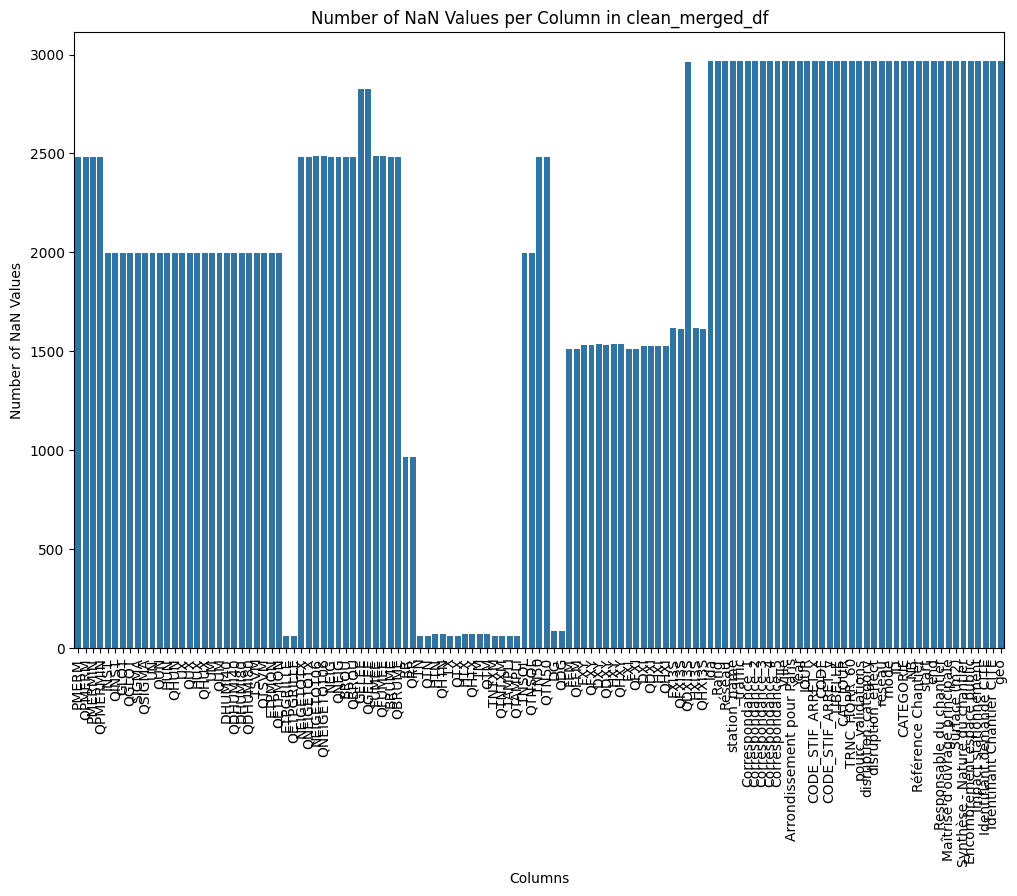

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming clean_merged_df is already defined and contains the data

# Check the number of NaN values per column
nan_counts = clean_merged_df.isna().sum()

# Display columns with NaN values
columns_with_nans = nan_counts[nan_counts > 0]

# Plot the number of NaN values per column
plt.figure(figsize=(12, 8))
sns.barplot(x=columns_with_nans.index, y=columns_with_nans.values)
plt.xticks(rotation=90)
plt.xlabel('Columns')
plt.ylabel('Number of NaN Values')
plt.title('Number of NaN Values per Column in clean_merged_df')
plt.show()


In [16]:
merged_back_up

,station_id,NOM_USUEL,LAT,LON,ALTI_x,date,PMERM,QPMERM,PMERMIN,QPMERMIN,...,CATEGORIE_TITRE_y,NB_VALD_y,CODE_STIF_TRNS,CODE_STIF_RES,CODE_STIF_ARRET_y,LIBELLE_ARRET,ID_REFA_LDA_y,CAT_JOUR,TRNC_HORR_60,pourc_validations
0,75106001,LUXEMBOURG,48.844667,2.333833,46.0,2023-01-01,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,75107005,TOUR EIFFEL,48.858333,2.294500,330.0,2023-01-01,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,75110001,LARIBOISIERE,48.882833,2.352000,55.0,2023-01-01,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,75112004,ST-ANTOINE,48.848167,2.380833,NaN,2023-01-01,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,75114001,PARIS-MONTSOURIS,48.821667,2.337833,75.0,2023-01-01,1014.9,1.0,1012.2,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2961,75107005,TOUR EIFFEL,48.858333,2.294500,330.0,2024-04-28,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2962,75110001,LARIBOISIERE,48.882833,2.352000,55.0,2024-04-28,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2963,75114001,PARIS-MONTSOURIS,48.821667,2.337833,75.0,2024-04-28,1010.8,1.0,1001.4,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2964,75114007,PARIS-MONTSOURIS-DOUBLE,48.821667,2.337833,75.0,2024-04-28,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
import pandas as pd
import json
import os
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming clean_merged_df, chantier_df, line_reports, and voies_df are already defined

# Merge chantier information
print("Merging chantier information...")
chantier_df['start_date'] = pd.to_datetime(chantier_df['start_date'])
chantier_df['end_date'] = pd.to_datetime(chantier_df['end_date'])
chantier_df['Code postal arrondissement - Commune'] = chantier_df['Code postal arrondissement - Commune'].astype(str)

clean_merged_df['Code postal arrondissement - Commune'] = clean_merged_df['station_id'].apply(lambda x: x[:5])
clean_merged_df = pd.merge(clean_merged_df, chantier_df, left_on='Code postal arrondissement - Commune', right_on='Code postal arrondissement - Commune', how='left')

# Join line reports
def get_disruption_info(station_id, line_reports):
    for report in line_reports:
        for disruption in report.get('disruptions', []):
            for obj in disruption.get('impacted_objects', []):
                if obj['pt_object']['id'] == station_id:
                    return disruption['category'], disruption['severity']['effect']
    return None, None

print("Adding line report information...")
clean_merged_df[['disruption_category', 'disruption_effect']] = clean_merged_df['station_id'].apply(lambda x: get_disruption_info(x, line_reports)).apply(pd.Series)

# Join voie information
def match_voie(station_id, voies_df):
    for _, voie in voies_df.iterrows():
        for coord in voie['coordinates']:
            if station_id in coord:
                return voie['reseau'], voie['mode']
    return None, None

clean_merged_df[['reseau', 'mode']] = clean_merged_df['station_id'].apply(lambda x: match_voie(x, voies_df)).apply(pd.Series)

# Create a binary column to indicate a problem
def has_probleme(row):
    if (pd.notnull(row.get('start_date')) and pd.notnull(row.get('end_date')) and row['start_date'] <= row['date'] <= row['end_date']) or \
       (pd.notnull(row.get('NEIG')) and row['NEIG'] > 0) or \
       (pd.notnull(row.get('RR')) and row['RR'] > 20) or \
       (pd.notnull(row.get('traffic')) and row['traffic'] > 200000) or \
       (pd.notnull(row.get('NB_VALD')) and row['NB_VALD'] > 1500):
        return 1
    return 0

clean_merged_df['probleme'] = clean_merged_df.apply(has_probleme, axis=1)

# Define features and target
X = clean_merged_df.drop(columns=['probleme'])
y = clean_merged_df['probleme']

# Select numeric and categorical features
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Pipeline for categorical features
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformations in a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Complete pipeline with preprocessing and model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Apply Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Training and evaluating the model with Stratified K-Fold Cross-Validation...")
cross_val_scores = cross_val_score(model, X, y, cv=skf, scoring='accuracy')
print(f"Cross-Validation Accuracy Scores: {cross_val_scores}")
print(f"Mean Cross-Validation Accuracy: {np.mean(cross_val_scores)}")

# Train the model on the full training set and evaluate on the test set
print("Training the model on the full training set...")
model.fit(X, y)
print("Model trained.")

# Visualize results
print("Visualizing results...")
# Extract feature importances
importances = model.named_steps['classifier'].feature_importances_

# Get feature names after OneHotEncoding
encoder = model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder']
encoder.fit(X[categorical_features])
encoded_cat_features = encoder.get_feature_names_out(categorical_features)

# Combine feature names
feature_names = np.hstack([numeric_features, encoded_cat_features])

# Visualize feature importances
feature_importances = pd.Series(importances, index=feature_names)
feature_importances.nlargest(10).plot(kind='barh')
plt.show()

# Heatmap of correlations
print("Visualizing correlations...")
corr_matrix = clean_merged_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


Merging chantier information...
Adding line report information...
Training and evaluating the model with Stratified K-Fold Cross-Validation...


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\pipeline.py", line 471, in fit
    Xt = self._fit(X, y, routed_params)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\pipeline.py", line 408, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\joblib\memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\pipeline.py", line 1303, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\utils\_set_output.py", line 295, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\compose\_column_transformer.py", line 906, in fit_transform
    self._validate_column_callables(X)
  File "c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\compose\_column_transformer.py", line 496, in _validate_column_callables
    transformer_to_input_indices[name] = _get_column_indices(X, columns)
                                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\utils\__init__.py", line 507, in _get_column_indices
    raise ValueError(
ValueError: Selected columns, ['LAT', 'LON', 'PMERM', 'QPMERM', 'PMERMIN', 'QPMERMIN', 'INST', 'QINST', 'GLOT', 'QGLOT', 'SIGMA', 'QSIGMA', 'UN', 'QUN', 'HUN', 'QHUN', 'UX', 'QUX', 'HUX', 'QHUX', 'UM', 'QUM', 'DHUMI40', 'QDHUMI40', 'DHUMI80', 'QDHUMI80', 'TSVM', 'QTSVM', 'ETPMON', 'QETPMON', 'ETPGRILLE', 'QETPGRILLE', 'NEIGETOTX', 'QNEIGETOTX', 'NEIGETOT06', 'QNEIGETOT06', 'NEIG', 'QNEIG', 'BROU', 'QBROU', 'GELEE', 'QGELEE', 'FUMEE', 'QFUMEE', 'BRUME', 'QBRUME', 'RR', 'QRR', 'TN', 'QTN', 'HTN', 'QHTN', 'TX', 'QTX', 'HTX', 'QHTX', 'TM', 'QTM', 'TNTXM', 'QTNTXM', 'TAMPLI', 'QTAMPLI', 'TNSOL', 'QTNSOL', 'TN50', 'QTN50', 'DG', 'QDG', 'FFM', 'QFFM', 'FXY', 'QFXY', 'DXY', 'QDXY', 'HXY', 'QHXY', 'FXI', 'QFXI', 'DXI', 'QDXI', 'HXI', 'QHXI', 'FXI3S', 'QFXI3S', 'QDXI3S', 'HXI3S', 'QHXI3S', 'lda', 'Rang', 'traffic', 'Correspondance_4', 'Correspondance_5', 'Arrondissement pour Paris', 'Year', 'CODE', 'ALTI', 'CODE', 'LIBELLE', 'ID', 'CATEGORIE', 'NB', 'Référence Chantier_x', 'Responsable du chantier_x', "Maîtrise d'ouvrage principale_x", 'Surface (m2)_x', 'Synthèse - Nature du chantier_x', 'Encombrement espace public_x', 'Impact stationnement_x', 'Identifiant demande CITE_x', 'Identifiant Chantier CITE_x', 'geo', 'Surface (m2)_y', 'Identifiant demande CITE_y', 'Identifiant Chantier CITE_y', 'Surface (m2)', 'Identifiant demande CITE', 'Identifiant Chantier CITE'], are not unique in dataframe


Loading datasets...
Chargement du JSON des voies ferrées...
JSON des voies ferrées chargé.
Extraction des informations du JSON des voies ferrées...
Informations des voies ferrées extraites.
Loading additional datasets...
Loading part-00000-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv...
Loading part-00001-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv...
Loading part-00002-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv...
Loading part-00003-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv...
Loading part-00004-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv...
Loading part-00005-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv...
Loading part-00006-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv...
Loading part-00007-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv...
Loading part-00008-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv...
Loading part-00009-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv...
Loading part-00010-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv...
Loading part-00011-4bea7afa-2c5

c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\SKONIECZNY\anaconda

Cross-Validation Accuracy Scores: [0.99158249 0.99325464 0.99325464 0.99325464 0.99325464]
Mean Cross-Validation Accuracy: 0.9929202082659081
Training the model on the full dataset...


c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Model trained.
Visualizing results...


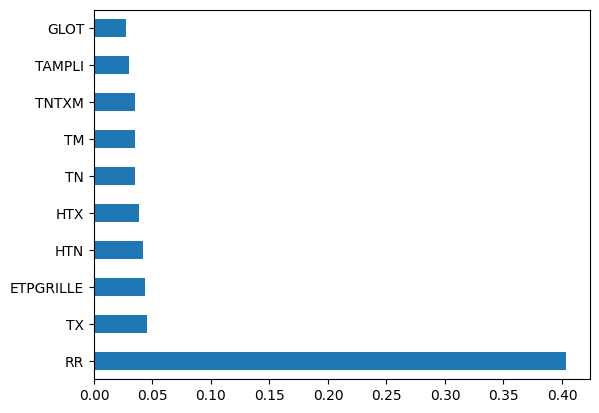

In [34]:
import pandas as pd
import json
import os
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function to convert dates with different formats
def parse_dates(date_str):
    try:
        return pd.to_datetime(date_str, format='%d/%m/%Y', errors='raise')
    except ValueError:
        try:
            return pd.to_datetime(date_str, format='%Y-%m-%d', errors='raise')
        except ValueError:
            if isinstance(date_str, str) and 'S' in date_str:
                year = int(date_str[:4])
                semester = int(date_str[-1])
                month = 1 if semester == 1 else 7
                return pd.Timestamp(year=year, month=month, day=1)
            else:
                return pd.NaT

# Function to load JSON data
def load_json(file_path):
    with open(file_path, 'r') as file:
        return json.load(file)

# Function to read large CSV files in smaller chunks
def read_csv_in_chunks(file_path, chunk_size=10000):
    reader = pd.read_csv(file_path, dtype={'1': str, '2': str, '4': str}, chunksize=chunk_size, on_bad_lines='skip')
    chunks = []
    for chunk in reader:
        chunks.append(chunk)
    return pd.concat(chunks, ignore_index=True)

# Function to load all CSV files from a directory
def load_all_csv_from_dir(directory, chunk_size=10000):
    all_data = []
    for file in os.listdir(directory):
        if file.endswith('.csv'):
            print(f"Loading {file}...")
            try:
                data = read_csv_in_chunks(os.path.join(directory, file), chunk_size=chunk_size)
                all_data.append(data)
            except Exception as e:
                print(f"Error loading {file}: {e}")
    return pd.concat(all_data, ignore_index=True)

# Load datasets
print("Loading datasets...")
weather_df = pd.read_csv('./all_weather/2023-2024-weather_cleaned.csv')
traffic_df = pd.read_csv('./freq_arret/2013-2021_trafic.csv')
validations_df = pd.read_csv('./freq_arret/validations-reseau-ferre-nombre-validations-par-jour-1er-semestre.csv', sep=';')
chantier_df = pd.read_csv('./chantier2019-2022.csv')

print("Chargement du JSON des voies ferrées...")
with open(r'C:\Users\SKONIECZNY\Desktop\Transport_App\client\src\common\traces-du-reseau-ferre-idf.json', 'r') as file:
    voie_data = json.load(file)
print("JSON des voies ferrées chargé.")

# Extraire les informations du JSON des voies ferrées
print("Extraction des informations du JSON des voies ferrées...")
voies_list = []
for feature in voie_data['features']:
    properties = feature['properties']
    coordinates = feature['geometry']['coordinates']
    voie = {
        'idrefliga': properties['idrefliga'],
        'reseau': properties['reseau'],
        'mode': properties['mode'],
        'coordinates': coordinates
    }
    voies_list.append(voie)
voies_df = pd.DataFrame(voies_list)
print("Informations des voies ferrées extraites.")

# Load additional CSV files from directories
print("Loading additional datasets...")
merged_nb_fer_df = load_all_csv_from_dir('./validation/merged_NB_FER.csv/')
merged_profil_df = load_all_csv_from_dir('./validation/merged_PROFIL.csv/')

# Load JSON files for line reports
print("Loading line report JSON data...")
line_report_files = [f'./line-report/{file}' for file in os.listdir('./line-report') if file.endswith('.json')]
line_reports = [load_json(file) for file in line_report_files]

# Load additional CSV files
print("Loading specific additional CSV files...")
additional_csv_files = [
    './freq_arret/arrets.csv',
    './freq_arret/validations-reseau-ferre-nombre-validations-par-jour-1er-semestre.csv',
    './freq_arret/validations-reseau-ferre-profils-horaires-par-jour-type-1er-semestre.csv',
    './indicateurs-qualite-service-sncf-ratp.csv',
    './TravauxSNCF_RATP_2019-2022.csv',
]

additional_dfs = [read_csv_in_chunks(file) for file in additional_csv_files]

# Combine all additional CSV dataframes
additional_df = pd.concat(additional_dfs, ignore_index=True)

print("Datasets loaded.")

# Preprocess data
print("Preprocessing data...")

# Rename columns for easier merging
print("Renaming columns...")
weather_df.rename(columns={'NUM_POSTE': 'station_id', 'AAAAMMJJ': 'date'}, inplace=True)
traffic_df.rename(columns={'Station': 'station_name', 'Trafic': 'traffic'}, inplace=True)
validations_df.rename(columns={'CODE_STIF_ARRET': 'station_id', 'JOUR': 'date'}, inplace=True)
chantier_df.rename(columns={'Date début du chantier': 'start_date', 'Date fin du chantier': 'end_date'}, inplace=True)
print("Columns renamed.")

# Convert 'station_id' to string for the two dataframes before merging
print("Converting data types...")
weather_df['station_id'] = weather_df['station_id'].astype(str)
validations_df['station_id'] = validations_df['station_id'].astype(str)
merged_nb_fer_df['station_id'] = merged_nb_fer_df['CODE_STIF_ARRET'].astype(str)
merged_profil_df['station_id'] = merged_profil_df['CODE_STIF_ARRET'].astype(str)

# Convert dates to datetime format
weather_df['date'] = pd.to_datetime(weather_df['date'], format='%Y%m%d')
validations_df['date'] = pd.to_datetime(validations_df['date'], format='%Y-%m-%d')
chantier_df['start_date'] = pd.to_datetime(chantier_df['start_date'])
chantier_df['end_date'] = pd.to_datetime(chantier_df['end_date'])
merged_nb_fer_df['date'] = merged_nb_fer_df['date'].apply(parse_dates)
merged_profil_df['date'] = merged_profil_df['date'].apply(parse_dates)
print("Data types converted.")

# Merge datasets on stations and dates
print("Merging datasets...")
merged_df = pd.merge(weather_df, validations_df, on=['station_id', 'date'], how='left')
merged_df = pd.merge(merged_df, traffic_df, left_on='station_id', right_on='station_name', how='left')
merged_df = pd.merge(merged_df, merged_nb_fer_df, on=['station_id', 'date'], how='left')
merged_df = pd.merge(merged_df, merged_profil_df, on=['station_id', 'date'], how='left')

# Ensure chantier_df is merged to include 'start_date' and 'end_date'
print("Merging chantier information...")
chantier_df['start_date'] = pd.to_datetime(chantier_df['start_date'])
chantier_df['end_date'] = pd.to_datetime(chantier_df['end_date'])
chantier_df['Code postal arrondissement - Commune'] = chantier_df['Code postal arrondissement - Commune'].astype(str)

merged_df['Code postal arrondissement - Commune'] = merged_df['station_id'].apply(lambda x: x[:5])
merged_df = pd.merge(merged_df, chantier_df, left_on='Code postal arrondissement - Commune', right_on='Code postal arrondissement - Commune', how='left')

# Join line reports (process disruptions to include them in the merged dataframe)
def get_disruption_info(station_id, line_reports):
    for report in line_reports:
        for disruption in report.get('disruptions', []):
            for obj in disruption.get('impacted_objects', []):
                if obj['pt_object']['id'] == station_id:
                    return disruption['category'], disruption['severity']['effect']
    return None, None

print("Adding line report information...")
merged_df[['disruption_category', 'disruption_effect']] = merged_df['station_id'].apply(lambda x: get_disruption_info(x, line_reports)).apply(pd.Series)

# Join voie information
print("Adding voie information...")
def match_voie(station_id, voies_df):
    for _, voie in voies_df.iterrows():
        for coord in voie['coordinates']:
            if station_id in coord:
                return voie['reseau'], voie['mode']
    return None, None

merged_df[['reseau', 'mode']] = merged_df['station_id'].apply(lambda x: match_voie(x, voies_df)).apply(pd.Series)

# Create a binary column to indicate a problem
print("Creating 'probleme' column...")
def has_probleme(row):
    probleme = 0
    if (pd.notnull(row.get('start_date')) and pd.notnull(row.get('end_date')) and row['start_date'] <= row['date'] <= row['end_date']) or \
       (pd.notnull(row.get('NEIG')) and row['NEIG'] > 3) or \
       (pd.notnull(row.get('RR')) and row['RR'] > 20) or \
       (pd.notnull(row.get('traffic')) and row['traffic'] > 200000) or \
       (pd.notnull(row.get('NB_VALD')) and row['NB_VALD'] > 2500):
        probleme = 1
    
    if pd.notnull(row.get('disruption_category')) or pd.notnull(row.get('disruption_effect')):
        probleme += 1
    
    return probleme

merged_df['probleme'] = merged_df.apply(has_probleme, axis=1)
print("Colonne 'probleme' créée.")

# 3. Split data into training and testing sets using StratifiedKFold
print("Splitting data into training and testing sets using StratifiedKFold...")
X = merged_df.drop(columns=['probleme'])
y = merged_df['probleme']

# Select numeric and categorical features
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Pipeline for categorical features
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformations in a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Complete pipeline with preprocessing and model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Apply StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Training and evaluating the model with Stratified K-Fold Cross-Validation...")
cross_val_scores = cross_val_score(model, X, y, cv=skf, scoring='accuracy')
print(f"Cross-Validation Accuracy Scores: {cross_val_scores}")
print(f"Mean Cross-Validation Accuracy: {np.mean(cross_val_scores)}")

# Train the model on the full dataset
print("Training the model on the full dataset...")
model.fit(X, y)
print("Model trained.")

# Visualize results
print("Visualizing results...")
# Extract feature importances
importances = model.named_steps['classifier'].feature_importances_

# Get feature names after OneHotEncoding
encoder = model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder']
encoded_cat_features = encoder.get_feature_names_out(categorical_features)

# Combine feature names
feature_names = np.hstack([numeric_features, encoded_cat_features])

# Visualize feature importances
feature_importances = pd.Series(importances, index=feature_names)
feature_importances.nlargest(10).plot(kind='barh')
plt.show()




Visualizing correlations...


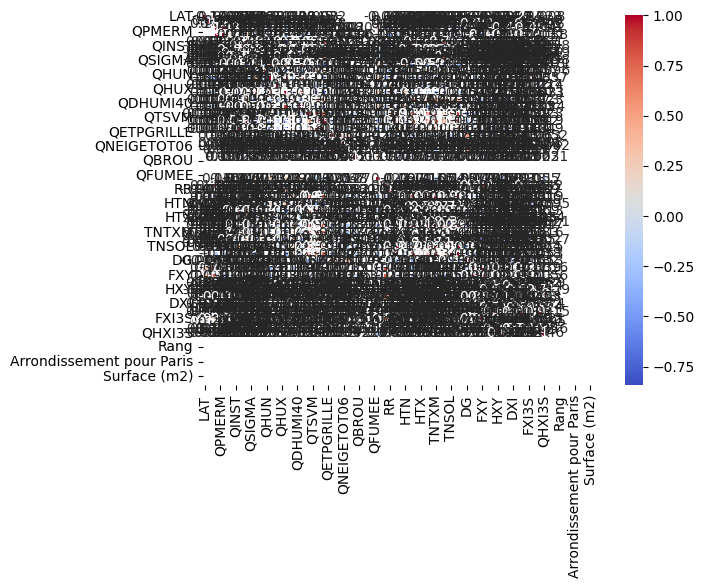

Example prediction with probability for a given station...
Station ID: 75106001
Coordinates: N/A
Prediction: No Probleme
Probabilities: [1. 0.]


In [35]:
# Heatmap of correlations
print("Visualizing correlations...")
numeric_df = merged_df[numeric_features]
corr_matrix = numeric_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

# Example of returning coordinates and probability for a given station
print("Example prediction with probability for a given station...")
example_station_id = merged_df.iloc[0]['station_id']
example_row = merged_df[merged_df['station_id'] == example_station_id].drop(columns=['probleme']).iloc[0].to_frame().T
example_prediction = model.predict(example_row)[0]
example_proba = model.predict_proba(example_row)[0]

print(f"Station ID: {example_station_id}")
print(f"Coordinates: {merged_df[merged_df['station_id'] == example_station_id]['coordinates'].values[0] if 'coordinates' in merged_df.columns else 'N/A'}")
print(f"Prediction: {'Probleme' if example_prediction == 1 else 'No Probleme'}")
print(f"Probabilities: {example_proba}")

In [36]:
merged_df

,station_id,NOM_USUEL,LAT,LON,ALTI_x,date,PMERM,QPMERM,PMERMIN,QPMERMIN,INST,QINST,GLOT,QGLOT,SIGMA,QSIGMA,UN,QUN,HUN,QHUN,UX,QUX,HUX,QHUX,UM,QUM,DHUMI40,QDHUMI40,DHUMI80,QDHUMI80,TSVM,QTSVM,ETPMON,QETPMON,ETPGRILLE,QETPGRILLE,NEIGETOTX,QNEIGETOTX,NEIGETOT06,QNEIGETOT06,NEIG,QNEIG,BROU,QBROU,GELEE,QGELEE,FUMEE,QFUMEE,BRUME,QBRUME,ALTI_y,RR,QRR,TN,QTN,HTN,QHTN,TX,QTX,HTX,QHTX,TM,QTM,TNTXM,QTNTXM,TAMPLI,QTAMPLI,TNSOL,QTNSOL,TN50,QTN50,DG,QDG,FFM,QFFM,FXY,QFXY,DXY,QDXY,HXY,QHXY,FXI,QFXI,DXI,QDXI,HXI,QHXI,FXI3S,QFXI3S,QDXI3S,HXI3S,QHXI3S,CODE_STIF_TRNS_x,CODE_STIF_RES_x,LIBELLE_ARRET_x,lda,CATEGORIE_TITRE_x,NB_VALD_x,Rang,Réseau,station_name,traffic,Correspondance_1,Correspondance_2,Correspondance_3,Correspondance_4,Correspondance_5,Ville,Arrondissement pour Paris,Year,JOUR,CODE_STIF_TRNS_y,CODE_STIF_RES_y,CODE_STIF_ARRET_x,LIBELLE_ARRET_y,ID_REFA_LDA_x,CATEGORIE_TITRE_y,NB_VALD_y,CODE_STIF_TRNS,CODE_STIF_RES,CODE_STIF_ARRET_y,LIBELLE_ARRET,ID_REFA_LDA_y,CAT_JOUR,TRNC_HORR_60,pourc_validations,Code postal arrondissement - Commune,Référence Chantier,start_date,end_date,Responsable du chantier,Maîtrise d'ouvrage principale,Surface (m2),Synthèse - Nature du chantier,Encombrement espace public,Impact stationnement,Identifiant demande CITE,Identifiant Chantier CITE,geo_shape,geo_point_2d,disruption_category,disruption_effect,reseau,mode,probleme
0,75106001,LUXEMBOURG,48.844667,2.333833,46.0,2023-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.1,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46,4.6,1.0,11.7,1.0,1450.0,9.0,15.3,1.0,2304.0,9.0,13.6,1.0,13.5,1.0,3.6,1.0,NaN,NaN,NaN,NaN,0.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75106,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,0
1,75107005,TOUR EIFFEL,48.858333,2.294500,330.0,2023-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,330,NaN,NaN,9.7,1.0,1448.0,9.0,14.7,1.0,2123.0,9.0,12.2,1.0,12.2,1.0,5.0,1.0,NaN,NaN,NaN,NaN,0.0,9.0,11.5,1.0,16.3,1.0,200.0,1.0,51.0,9.0,24.7,1.0,210.0,9.0,2004.0,9.0,23.2,9.0,NaN,2206.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75107,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,0
2,75110001,LARIBOISIERE,48.882833,2.352000,55.0,2023-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.1,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55,4.0,1.0,12.1,1.0,1431.0,9.0,15.6,1.0,2306.0,9.0,14.0,1.0,13.9,1.0,3.5,1.0,NaN,NaN,NaN,NaN,0.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75110,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,0
3,75112004,ST-ANTOINE,48.848167,2.380833,NaN,2023-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36,4.5,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75112,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,0
4,75114001,PARIS-MONTSOURIS,48.821667,2.337833,75.0,2023-01-01,1014.9,1.0,1012.2,1.0,0.0,9.0,73.0,9.0,0.0,9.0,53.0,1.0,1.0,9.0,92

In [37]:
import pickle

# Save the model using pickle
with open('issue_prev.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)
print("Model saved as 'issue_prev.pkl'.")

Model saved as 'issue_prev.pkl'.


Loading datasets...
Chargement du JSON des voies ferrées...
JSON des voies ferrées chargé.
Extraction des informations du JSON des voies ferrées...
Informations des voies ferrées extraites.
Loading additional datasets...
Loading part-00000-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv...
Loading part-00001-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv...
Loading part-00002-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv...
Loading part-00003-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv...
Loading part-00004-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv...
Loading part-00005-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv...
Loading part-00006-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv...
Loading part-00007-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv...
Loading part-00008-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv...
Loading part-00009-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv...
Loading part-00010-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv...
Loading part-00011-4bea7afa-2c5

c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\SKONIECZNY\anaconda

Cross-Validation Accuracy Scores: [0.99157895 0.99157895 0.99578059 0.99578059 0.99156118]
Mean Cross-Validation Accuracy: 0.993256051521208
Training the model on the training set...


c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Model trained.
Evaluating the model on the test set...
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       589
           1       0.00      0.00      0.00         5

    accuracy                           0.99       594
   macro avg       0.50      0.50      0.50       594
weighted avg       0.98      0.99      0.99       594

Test Accuracy: 0.9915824915824916
Model saved as 'issue_prev_2.pkl'.
Visualizing results...


c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

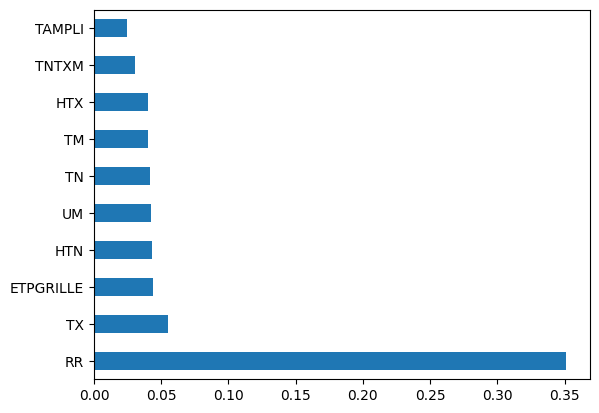

Visualizing correlations...


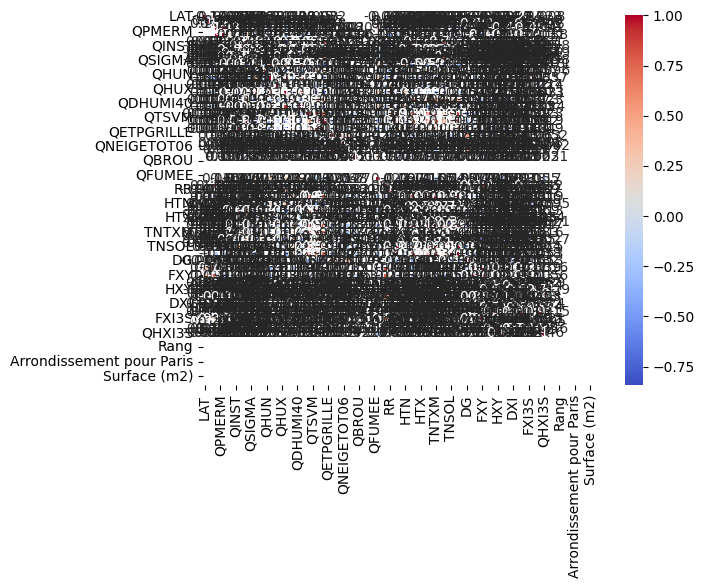

In [38]:
import pandas as pd
import json
import os
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle  # Import the pickle module

# Function to convert dates with different formats
def parse_dates(date_str):
    try:
        return pd.to_datetime(date_str, format='%d/%m/%Y', errors='raise')
    except ValueError:
        try:
            return pd.to_datetime(date_str, format='%Y-%m-%d', errors='raise')
        except ValueError:
            if isinstance(date_str, str) and 'S' in date_str:
                year = int(date_str[:4])
                semester = int(date_str[-1])
                month = 1 if semester == 1 else 7
                return pd.Timestamp(year=year, month=month, day=1)
            else:
                return pd.NaT

# Function to load JSON data
def load_json(file_path):
    with open(file_path, 'r') as file:
        return json.load(file)

# Function to read large CSV files in smaller chunks
def read_csv_in_chunks(file_path, chunk_size=10000):
    reader = pd.read_csv(file_path, dtype={'1': str, '2': str, '4': str}, chunksize=chunk_size, on_bad_lines='skip')
    chunks = []
    for chunk in reader:
        chunks.append(chunk)
    return pd.concat(chunks, ignore_index=True)

# Function to load all CSV files from a directory
def load_all_csv_from_dir(directory, chunk_size=10000):
    all_data = []
    for file in os.listdir(directory):
        if file.endswith('.csv'):
            print(f"Loading {file}...")
            try:
                data = read_csv_in_chunks(os.path.join(directory, file), chunk_size=chunk_size)
                all_data.append(data)
            except Exception as e:
                print(f"Error loading {file}: {e}")
    return pd.concat(all_data, ignore_index=True)

# Load datasets
print("Loading datasets...")
weather_df = pd.read_csv('./all_weather/2023-2024-weather_cleaned.csv')
traffic_df = pd.read_csv('./freq_arret/2013-2021_trafic.csv')
validations_df = pd.read_csv('./freq_arret/validations-reseau-ferre-nombre-validations-par-jour-1er-semestre.csv', sep=';')
chantier_df = pd.read_csv('./chantier2019-2022.csv')

print("Chargement du JSON des voies ferrées...")
with open(r'C:\Users\SKONIECZNY\Desktop\Transport_App\client\src\common\traces-du-reseau-ferre-idf.json', 'r') as file:
    voie_data = json.load(file)
print("JSON des voies ferrées chargé.")

# Extraire les informations du JSON des voies ferrées
print("Extraction des informations du JSON des voies ferrées...")
voies_list = []
for feature in voie_data['features']:
    properties = feature['properties']
    coordinates = feature['geometry']['coordinates']
    voie = {
        'idrefliga': properties['idrefliga'],
        'reseau': properties['reseau'],
        'mode': properties['mode'],
        'coordinates': coordinates
    }
    voies_list.append(voie)
voies_df = pd.DataFrame(voies_list)
print("Informations des voies ferrées extraites.")

# Load additional CSV files from directories
print("Loading additional datasets...")
merged_nb_fer_df = load_all_csv_from_dir('./validation/merged_NB_FER.csv/')
merged_profil_df = load_all_csv_from_dir('./validation/merged_PROFIL.csv/')

# Load JSON files for line reports
print("Loading line report JSON data...")
line_report_files = [f'./line-report/{file}' for file in os.listdir('./line-report') if file.endswith('.json')]
line_reports = [load_json(file) for file in line_report_files]

# Load additional CSV files
print("Loading specific additional CSV files...")
additional_csv_files = [
    './freq_arret/arrets.csv',
    './freq_arret/validations-reseau-ferre-nombre-validations-par-jour-1er-semestre.csv',
    './freq_arret/validations-reseau-ferre-profils-horaires-par-jour-type-1er-semestre.csv',
    './indicateurs-qualite-service-sncf-ratp.csv',
    './TravauxSNCF_RATP_2019-2022.csv',
]

additional_dfs = [read_csv_in_chunks(file) for file in additional_csv_files]

# Combine all additional CSV dataframes
additional_df = pd.concat(additional_dfs, ignore_index=True)

print("Datasets loaded.")

# Preprocess data
print("Preprocessing data...")

# Rename columns for easier merging
print("Renaming columns...")
weather_df.rename(columns={'NUM_POSTE': 'station_id', 'AAAAMMJJ': 'date'}, inplace=True)
traffic_df.rename(columns={'Station': 'station_name', 'Trafic': 'traffic'}, inplace=True)
validations_df.rename(columns={'CODE_STIF_ARRET': 'station_id', 'JOUR': 'date'}, inplace=True)
chantier_df.rename(columns={'Date début du chantier': 'start_date', 'Date fin du chantier': 'end_date'}, inplace=True)
print("Columns renamed.")

# Convert 'station_id' to string for the two dataframes before merging
print("Converting data types...")
weather_df['station_id'] = weather_df['station_id'].astype(str)
validations_df['station_id'] = validations_df['station_id'].astype(str)
merged_nb_fer_df['station_id'] = merged_nb_fer_df['CODE_STIF_ARRET'].astype(str)
merged_profil_df['station_id'] = merged_profil_df['CODE_STIF_ARRET'].astype(str)

# Convert dates to datetime format
weather_df['date'] = pd.to_datetime(weather_df['date'], format='%Y%m%d')
validations_df['date'] = pd.to_datetime(validations_df['date'], format='%Y-%m-%d')
chantier_df['start_date'] = pd.to_datetime(chantier_df['start_date'])
chantier_df['end_date'] = pd.to_datetime(chantier_df['end_date'])
merged_nb_fer_df['date'] = merged_nb_fer_df['date'].apply(parse_dates)
merged_profil_df['date'] = merged_profil_df['date'].apply(parse_dates)
print("Data types converted.")

# Merge datasets on stations and dates
print("Merging datasets...")
merged_df = pd.merge(weather_df, validations_df, on=['station_id', 'date'], how='left')
merged_df = pd.merge(merged_df, traffic_df, left_on='station_id', right_on='station_name', how='left')
merged_df = pd.merge(merged_df, merged_nb_fer_df, on=['station_id', 'date'], how='left')
merged_df = pd.merge(merged_df, merged_profil_df, on=['station_id', 'date'], how='left')

# Ensure chantier_df is merged to include 'start_date' and 'end_date'
print("Merging chantier information...")
chantier_df['start_date'] = pd.to_datetime(chantier_df['start_date'])
chantier_df['end_date'] = pd.to_datetime(chantier_df['end_date'])
chantier_df['Code postal arrondissement - Commune'] = chantier_df['Code postal arrondissement - Commune'].astype(str)

merged_df['Code postal arrondissement - Commune'] = merged_df['station_id'].apply(lambda x: x[:5])
merged_df = pd.merge(merged_df, chantier_df, left_on='Code postal arrondissement - Commune', right_on='Code postal arrondissement - Commune', how='left')

# Join line reports (process disruptions to include them in the merged dataframe)
def get_disruption_info(station_id, line_reports):
    for report in line_reports:
        for disruption in report.get('disruptions', []):
            for obj in disruption.get('impacted_objects', []):
                if obj['pt_object']['id'] == station_id:
                    return disruption['category'], disruption['severity']['effect']
    return None, None

print("Adding line report information...")
merged_df[['disruption_category', 'disruption_effect']] = merged_df['station_id'].apply(lambda x: get_disruption_info(x, line_reports)).apply(pd.Series)

# Join voie information
print("Adding voie information...")
def match_voie(station_id, voies_df):
    for _, voie in voies_df.iterrows():
        for coord in voie['coordinates']:
            if station_id in coord:
                return voie['reseau'], voie['mode']
    return None, None

merged_df[['reseau', 'mode']] = merged_df['station_id'].apply(lambda x: match_voie(x, voies_df)).apply(pd.Series)

# Create a binary column to indicate a problem
print("Creating 'probleme' column...")
def has_probleme(row):
    probleme = 0
    if (pd.notnull(row.get('start_date')) and pd.notnull(row.get('end_date')) and row['start_date'] <= row['date'] <= row['end_date']) or \
       (pd.notnull(row.get('NEIG')) and row['NEIG'] > 3) or \
       (pd.notnull(row.get('RR')) and row['RR'] > 20) or \
       (pd.notnull(row.get('traffic')) and row['traffic'] > 200000) or \
       (pd.notnull(row.get('NB_VALD')) and row['NB_VALD'] > 2500):
        probleme = 1
    
    if pd.notnull(row.get('disruption_category')) or pd.notnull(row.get('disruption_effect')):
        probleme += 1
    
    return probleme

merged_df['probleme'] = merged_df.apply(has_probleme, axis=1)
print("Colonne 'probleme' créée.")

# Split data into training and testing sets
print("Splitting data into training and testing sets...")
X = merged_df.drop(columns=['probleme'])
y = merged_df['probleme']

# Stratify split to preserve class distribution
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Select numeric and categorical features
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Pipeline for categorical features
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformations in a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Complete pipeline with preprocessing and model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Apply StratifiedKFold on the training set
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Training and evaluating the model with Stratified K-Fold Cross-Validation...")
cross_val_scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy')
print(f"Cross-Validation Accuracy Scores: {cross_val_scores}")
print(f"Mean Cross-Validation Accuracy: {np.mean(cross_val_scores)}")

# Train the model on the training set
print("Training the model on the training set...")
model.fit(X_train, y_train)
print("Model trained.")

# Evaluate the model on the test set
print("Evaluating the model on the test set...")
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")

# Save the model using pickle
with open('issue_prev_2.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)
print("Model saved as 'issue_prev_2.pkl'.")

# Visualize results
print("Visualizing results...")
# Extract feature importances
importances = model.named_steps['classifier'].feature_importances_

# Get feature names after OneHotEncoding
encoder = model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder']
encoded_cat_features = encoder.get_feature_names_out(categorical_features)

# Combine feature names
feature_names = np.hstack([numeric_features, encoded_cat_features])

# Visualize feature importances
feature_importances = pd.Series(importances, index=feature_names)
feature_importances.nlargest(10).plot(kind='barh')
plt.show()

# Heatmap of correlations
print("Visualizing correlations...")
numeric_df = merged_df[numeric_features]
corr_matrix = numeric_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


Loading datasets...
Chargement du JSON des voies ferrées...
JSON des voies ferrées chargé.
Extraction des informations du JSON des voies ferrées...
Informations des voies ferrées extraites.
Loading additional datasets...
Loading part-00000-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv...
Loading part-00001-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv...
Loading part-00002-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv...
Loading part-00003-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv...
Loading part-00004-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv...
Loading part-00005-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv...
Loading part-00006-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv...
Loading part-00007-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv...
Loading part-00008-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv...
Loading part-00009-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv...
Loading part-00010-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv...
Loading part-00011-4bea7afa-2c5

c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\SKONIECZNY\anaconda

Cross-Validation Accuracy Scores: [0.99157895 0.99157895 0.99578059 0.99578059 0.99156118]
Mean Cross-Validation Accuracy: 0.993256051521208
Training the model on the training set...


c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Model trained.
Evaluating the model on the test set...
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       589
           1       0.00      0.00      0.00         5

    accuracy                           0.99       594
   macro avg       0.50      0.50      0.50       594
weighted avg       0.98      0.99      0.99       594

Test Accuracy: 0.9915824915824916
Model saved as 'issue_prev_2.pkl'.
Visualizing results...


c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

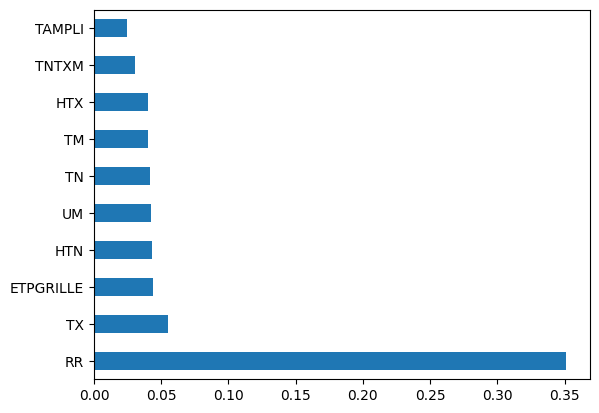

Visualizing correlations...


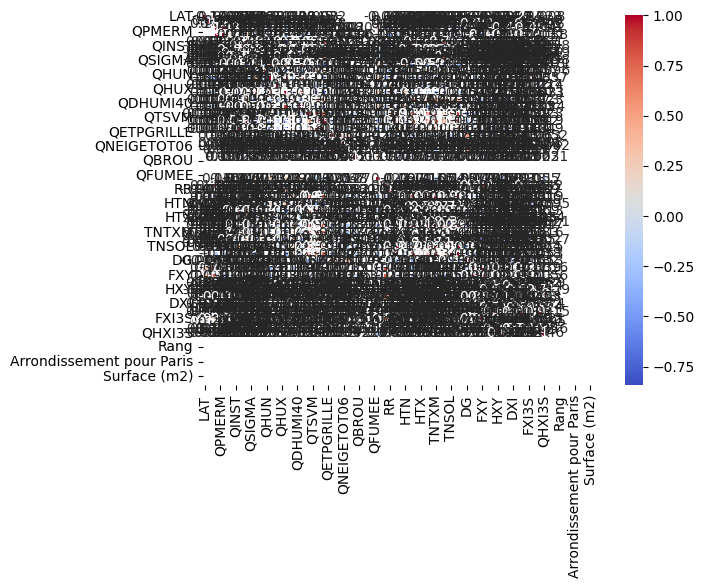

merged_df saved to 'merged_df.csv'.


In [3]:
import pandas as pd
import json
import os
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle  # Import the pickle module

# Function to convert dates with different formats
def parse_dates(date_str):
    try:
        return pd.to_datetime(date_str, format='%d/%m/%Y', errors='raise')
    except ValueError:
        try:
            return pd.to_datetime(date_str, format='%Y-%m-%d', errors='raise')
        except ValueError:
            if isinstance(date_str, str) and 'S' in date_str:
                year = int(date_str[:4])
                semester = int(date_str[-1])
                month = 1 if semester == 1 else 7
                return pd.Timestamp(year=year, month=month, day=1)
            else:
                return pd.NaT

# Function to load JSON data
def load_json(file_path):
    with open(file_path, 'r') as file:
        return json.load(file)

# Function to read large CSV files in smaller chunks
def read_csv_in_chunks(file_path, chunk_size=10000):
    reader = pd.read_csv(file_path, dtype={'1': str, '2': str, '4': str}, chunksize=chunk_size, on_bad_lines='skip')
    chunks = []
    for chunk in reader:
        chunks.append(chunk)
    return pd.concat(chunks, ignore_index=True)

# Function to load all CSV files from a directory
def load_all_csv_from_dir(directory, chunk_size=10000):
    all_data = []
    for file in os.listdir(directory):
        if file.endswith('.csv'):
            print(f"Loading {file}...")
            try:
                data = read_csv_in_chunks(os.path.join(directory, file), chunk_size=chunk_size)
                all_data.append(data)
            except Exception as e:
                print(f"Error loading {file}: {e}")
    return pd.concat(all_data, ignore_index=True)

# Load datasets
print("Loading datasets...")
weather_df = pd.read_csv('./all_weather/2023-2024-weather_cleaned.csv')
traffic_df = pd.read_csv('./freq_arret/2013-2021_trafic.csv')
validations_df = pd.read_csv('./freq_arret/validations-reseau-ferre-nombre-validations-par-jour-1er-semestre.csv', sep=';')
chantier_df = pd.read_csv('./chantier2019-2022.csv')

print("Chargement du JSON des voies ferrées...")
with open(r'C:\Users\SKONIECZNY\Desktop\Transport_App\client\src\common\traces-du-reseau-ferre-idf.json', 'r') as file:
    voie_data = json.load(file)
print("JSON des voies ferrées chargé.")

# Extraire les informations du JSON des voies ferrées
print("Extraction des informations du JSON des voies ferrées...")
voies_list = []
for feature in voie_data['features']:
    properties = feature['properties']
    coordinates = feature['geometry']['coordinates']
    voie = {
        'idrefliga': properties['idrefliga'],
        'reseau': properties['reseau'],
        'mode': properties['mode'],
        'coordinates': coordinates
    }
    voies_list.append(voie)
voies_df = pd.DataFrame(voies_list)
print("Informations des voies ferrées extraites.")

# Load additional CSV files from directories
print("Loading additional datasets...")
merged_nb_fer_df = load_all_csv_from_dir('./validation/merged_NB_FER.csv/')
merged_profil_df = load_all_csv_from_dir('./validation/merged_PROFIL.csv/')

# Load JSON files for line reports
print("Loading line report JSON data...")
line_report_files = [f'./line-report/{file}' for file in os.listdir('./line-report') if file.endswith('.json')]
line_reports = [load_json(file) for file in line_report_files]

# Load additional CSV files
print("Loading specific additional CSV files...")
additional_csv_files = [
    './freq_arret/arrets.csv',
    './freq_arret/validations-reseau-ferre-nombre-validations-par-jour-1er-semestre.csv',
    './freq_arret/validations-reseau-ferre-profils-horaires-par-jour-type-1er-semestre.csv',
    './indicateurs-qualite-service-sncf-ratp.csv',
    './TravauxSNCF_RATP_2019-2022.csv',
]

additional_dfs = [read_csv_in_chunks(file) for file in additional_csv_files]

# Combine all additional CSV dataframes
additional_df = pd.concat(additional_dfs, ignore_index=True)

print("Datasets loaded.")

# Preprocess data
print("Preprocessing data...")

# Rename columns for easier merging
print("Renaming columns...")
weather_df.rename(columns={'NUM_POSTE': 'station_id', 'AAAAMMJJ': 'date'}, inplace=True)
traffic_df.rename(columns={'Station': 'station_name', 'Trafic': 'traffic'}, inplace=True)
validations_df.rename(columns={'CODE_STIF_ARRET': 'station_id', 'JOUR': 'date'}, inplace=True)
chantier_df.rename(columns={'Date début du chantier': 'start_date', 'Date fin du chantier': 'end_date'}, inplace=True)
print("Columns renamed.")

# Convert 'station_id' to string for the two dataframes before merging
print("Converting data types...")
weather_df['station_id'] = weather_df['station_id'].astype(str)
validations_df['station_id'] = validations_df['station_id'].astype(str)
merged_nb_fer_df['station_id'] = merged_nb_fer_df['CODE_STIF_ARRET'].astype(str)
merged_profil_df['station_id'] = merged_profil_df['CODE_STIF_ARRET'].astype(str)

# Convert dates to datetime format
weather_df['date'] = pd.to_datetime(weather_df['date'], format='%Y%m%d')
validations_df['date'] = pd.to_datetime(validations_df['date'], format='%Y-%m-%d')
chantier_df['start_date'] = pd.to_datetime(chantier_df['start_date'])
chantier_df['end_date'] = pd.to_datetime(chantier_df['end_date'])
merged_nb_fer_df['date'] = merged_nb_fer_df['date'].apply(parse_dates)
merged_profil_df['date'] = merged_profil_df['date'].apply(parse_dates)
print("Data types converted.")

# Merge datasets on stations and dates
print("Merging datasets...")
merged_df = pd.merge(weather_df, validations_df, on=['station_id', 'date'], how='left')
merged_df = pd.merge(merged_df, traffic_df, left_on='station_id', right_on='station_name', how='left')
merged_df = pd.merge(merged_df, merged_nb_fer_df, on=['station_id', 'date'], how='left')
merged_df = pd.merge(merged_df, merged_profil_df, on=['station_id', 'date'], how='left')

# Ensure chantier_df is merged to include 'start_date' and 'end_date'
print("Merging chantier information...")
chantier_df['start_date'] = pd.to_datetime(chantier_df['start_date'])
chantier_df['end_date'] = pd.to_datetime(chantier_df['end_date'])
chantier_df['Code postal arrondissement - Commune'] = chantier_df['Code postal arrondissement - Commune'].astype(str)

merged_df['Code postal arrondissement - Commune'] = merged_df['station_id'].apply(lambda x: x[:5])
merged_df = pd.merge(merged_df, chantier_df, left_on='Code postal arrondissement - Commune', right_on='Code postal arrondissement - Commune', how='left')

# Join line reports (process disruptions to include them in the merged dataframe)
def get_disruption_info(station_id, line_reports):
    for report in line_reports:
        for disruption in report.get('disruptions', []):
            for obj in disruption.get('impacted_objects', []):
                if obj['pt_object']['id'] == station_id:
                    return disruption['category'], disruption['severity']['effect']
    return None, None

print("Adding line report information...")
merged_df[['disruption_category', 'disruption_effect']] = merged_df['station_id'].apply(lambda x: get_disruption_info(x, line_reports)).apply(pd.Series)

# Join voie information
print("Adding voie information...")
def match_voie(station_id, voies_df):
    for _, voie in voies_df.iterrows():
        for coord in voie['coordinates']:
            if station_id in coord:
                return voie['reseau'], voie['mode']
    return None, None

merged_df[['reseau', 'mode']] = merged_df['station_id'].apply(lambda x: match_voie(x, voies_df)).apply(pd.Series)

# Create a binary column to indicate a problem
print("Creating 'probleme' column...")
def has_probleme(row):
    probleme = 0
    if (pd.notnull(row.get('start_date')) and pd.notnull(row.get('end_date')) and row['start_date'] <= row['date'] <= row['end_date']) or \
       (pd.notnull(row.get('NEIG')) and row['NEIG'] > 3) or \
       (pd.notnull(row.get('RR')) and row['RR'] > 20) or \
       (pd.notnull(row.get('traffic')) and row['traffic'] > 200000) or \
       (pd.notnull(row.get('NB_VALD')) and row['NB_VALD'] > 2500):
        probleme = 1
    
    if pd.notnull(row.get('disruption_category')) or pd.notnull(row.get('disruption_effect')):
        probleme += 1
    
    return probleme

merged_df['probleme'] = merged_df.apply(has_probleme, axis=1)
print("Colonne 'probleme' créée.")

# Split data into training and testing sets
print("Splitting data into training and testing sets...")
X = merged_df.drop(columns=['probleme'])
y = merged_df['probleme']

# Stratify split to preserve class distribution
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Select numeric and categorical features
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Pipeline for categorical features
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformations in a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Complete pipeline with preprocessing and model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Apply StratifiedKFold on the training set
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Training and evaluating the model with Stratified K-Fold Cross-Validation...")
cross_val_scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy')
print(f"Cross-Validation Accuracy Scores: {cross_val_scores}")
print(f"Mean Cross-Validation Accuracy: {np.mean(cross_val_scores)}")

# Train the model on the training set
print("Training the model on the training set...")
model.fit(X_train, y_train)
print("Model trained.")

# Evaluate the model on the test set
print("Evaluating the model on the test set...")
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")

# Save the model using pickle
with open('issue_prev_2.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)
print("Model saved as 'issue_prev_2.pkl'.")

# Visualize results
print("Visualizing results...")
# Extract feature importances
importances = model.named_steps['classifier'].feature_importances_

# Get feature names after OneHotEncoding
encoder = model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder']
encoded_cat_features = encoder.get_feature_names_out(categorical_features)

# Combine feature names
feature_names = np.hstack([numeric_features, encoded_cat_features])

# Visualize feature importances
feature_importances = pd.Series(importances, index=feature_names)
feature_importances.nlargest(10).plot(kind='barh')
plt.show()

# Heatmap of correlations
print("Visualizing correlations...")
numeric_df = merged_df[numeric_features]
corr_matrix = numeric_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

# Save merged_df to CSV
merged_df.to_csv('merged_df.csv', index=False)
print("merged_df saved to 'merged_df.csv'.")
print("Example prediction with probability for a given station...")
example_station_id = merged_df.iloc[0]['station_id']
example_row = merged_df[merged_df['station_id'] == example_station_id].drop(columns=['probleme']).iloc[0].to_frame().T
example_prediction = model.predict(example_row)[0]
example_proba = model.predict_proba(example_row)[0]

print(f"Station ID: {example_station_id}")
print(f"Coordinates: {merged_df[merged_df['station_id'] == example_station_id]['coordinates'].values[0] if 'coordinates' in merged_df.columns else 'N/A'}")
print(f"Prediction: {'Probleme' if example_prediction == 1 else 'No Probleme'}")
print(f"Probabilities: {example_proba}")

Loading datasets...
Chargement du JSON des voies ferrées...
JSON des voies ferrées chargé.
Extraction des informations du JSON des voies ferrées...
Informations des voies ferrées extraites.
Loading additional datasets...
Loading part-00000-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv...
Loading part-00001-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv...
Loading part-00002-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv...
Loading part-00003-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv...
Loading part-00004-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv...
Loading part-00005-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv...
Loading part-00006-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv...
Loading part-00007-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv...
Loading part-00008-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv...
Loading part-00009-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv...
Loading part-00010-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv...
Loading part-00011-4bea7afa-2c5

c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\SKONIECZNY\anaconda

Cross-Validation Accuracy Scores: [0.99157895 0.99157895 0.99578059 0.99578059 0.99156118]
Mean Cross-Validation Accuracy: 0.993256051521208
Training the model on the training set...


c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Model trained.
Evaluating the model on the test set...
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       589
           1       0.00      0.00      0.00         5

    accuracy                           0.99       594
   macro avg       0.50      0.50      0.50       594
weighted avg       0.98      0.99      0.99       594

Test Accuracy: 0.9915824915824916
Model saved as 'issue_prev_voies.pkl'.
Visualizing results...


c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

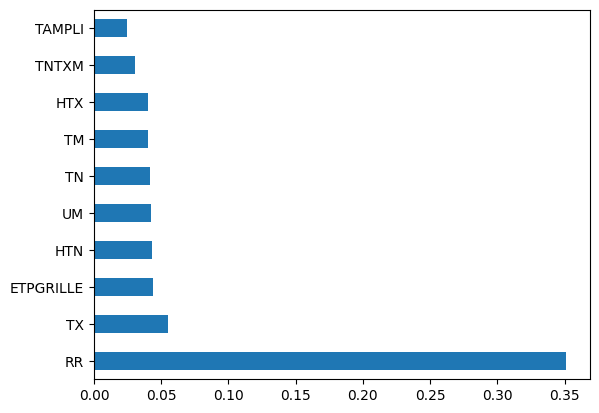

Visualizing correlations...


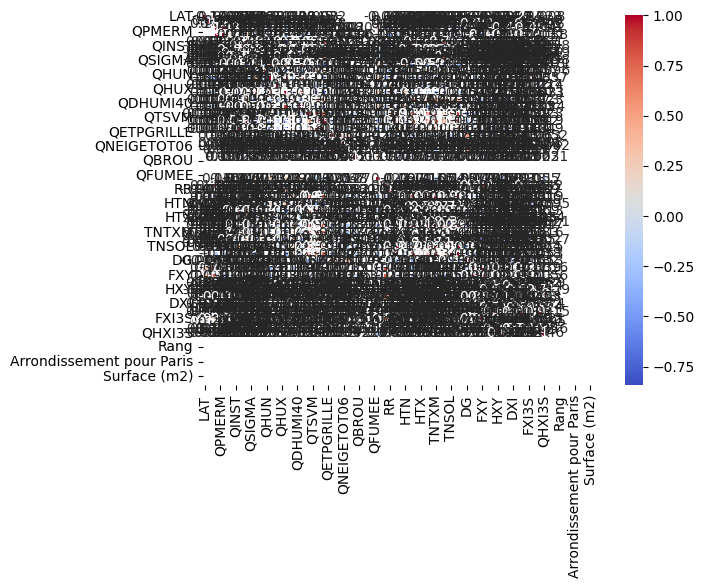

merged_df saved to 'merged_df_voies.csv'.
No data available for the provided voies: ['RER B', 'METRO 7']
None


In [4]:
import pandas as pd
import json
import os
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle  # Import the pickle module

# Function to convert dates with different formats
def parse_dates(date_str):
    try:
        return pd.to_datetime(date_str, format='%d/%m/%Y', errors='raise')
    except ValueError:
        try:
            return pd.to_datetime(date_str, format='%Y-%m-%d', errors='raise')
        except ValueError:
            if isinstance(date_str, str) and 'S' in date_str:
                year = int(date_str[:4])
                semester = int(date_str[-1])
                month = 1 if semester == 1 else 7
                return pd.Timestamp(year=year, month=month, day=1)
            else:
                return pd.NaT

# Function to load JSON data
def load_json(file_path):
    with open(file_path, 'r') as file:
        return json.load(file)

# Function to read large CSV files in smaller chunks
def read_csv_in_chunks(file_path, chunk_size=10000):
    reader = pd.read_csv(file_path, dtype={'1': str, '2': str, '4': str}, chunksize=chunk_size, on_bad_lines='skip')
    chunks = []
    for chunk in reader:
        chunks.append(chunk)
    return pd.concat(chunks, ignore_index=True)

# Function to load all CSV files from a directory
def load_all_csv_from_dir(directory, chunk_size=10000):
    all_data = []
    for file in os.listdir(directory):
        if file.endswith('.csv'):
            print(f"Loading {file}...")
            try:
                data = read_csv_in_chunks(os.path.join(directory, file), chunk_size=chunk_size)
                all_data.append(data)
            except Exception as e:
                print(f"Error loading {file}: {e}")
    return pd.concat(all_data, ignore_index=True)

# Load datasets
print("Loading datasets...")
weather_df = pd.read_csv('./all_weather/2023-2024-weather_cleaned.csv')
traffic_df = pd.read_csv('./freq_arret/2013-2021_trafic.csv')
validations_df = pd.read_csv('./freq_arret/validations-reseau-ferre-nombre-validations-par-jour-1er-semestre.csv', sep=';')
chantier_df = pd.read_csv('./chantier2019-2022.csv')

print("Chargement du JSON des voies ferrées...")
with open(r'C:\Users\SKONIECZNY\Desktop\Transport_App\client\src\common\traces-du-reseau-ferre-idf.json', 'r') as file:
    voie_data = json.load(file)
print("JSON des voies ferrées chargé.")

# Extraire les informations du JSON des voies ferrées
print("Extraction des informations du JSON des voies ferrées...")
voies_list = []
for feature in voie_data['features']:
    properties = feature['properties']
    coordinates = feature['geometry']['coordinates']
    voie = {
        'idrefliga': properties['idrefliga'],
        'reseau': properties['reseau'],
        'mode': properties['mode'],
        'coordinates': coordinates
    }
    voies_list.append(voie)
voies_df = pd.DataFrame(voies_list)
print("Informations des voies ferrées extraites.")

# Load additional CSV files from directories
print("Loading additional datasets...")
merged_nb_fer_df = load_all_csv_from_dir('./validation/merged_NB_FER.csv/')
merged_profil_df = load_all_csv_from_dir('./validation/merged_PROFIL.csv/')

# Load JSON files for line reports
print("Loading line report JSON data...")
line_report_files = [f'./line-report/{file}' for file in os.listdir('./line-report') if file.endswith('.json')]
line_reports = [load_json(file) for file in line_report_files]

# Load additional CSV files
print("Loading specific additional CSV files...")
additional_csv_files = [
    './freq_arret/arrets.csv',
    './freq_arret/validations-reseau-ferre-nombre-validations-par-jour-1er-semestre.csv',
    './freq_arret/validations-reseau-ferre-profils-horaires-par-jour-type-1er-semestre.csv',
    './indicateurs-qualite-service-sncf-ratp.csv',
    './TravauxSNCF_RATP_2019-2022.csv',
]

additional_dfs = [read_csv_in_chunks(file) for file in additional_csv_files]

# Combine all additional CSV dataframes
additional_df = pd.concat(additional_dfs, ignore_index=True)

print("Datasets loaded.")

# Preprocess data
print("Preprocessing data...")

# Rename columns for easier merging
print("Renaming columns...")
weather_df.rename(columns={'NUM_POSTE': 'station_id', 'AAAAMMJJ': 'date'}, inplace=True)
traffic_df.rename(columns={'Station': 'station_name', 'Trafic': 'traffic'}, inplace=True)
validations_df.rename(columns={'CODE_STIF_ARRET': 'station_id', 'JOUR': 'date'}, inplace=True)
chantier_df.rename(columns={'Date début du chantier': 'start_date', 'Date fin du chantier': 'end_date'}, inplace=True)
print("Columns renamed.")

# Convert 'station_id' to string for the two dataframes before merging
print("Converting data types...")
weather_df['station_id'] = weather_df['station_id'].astype(str)
validations_df['station_id'] = validations_df['station_id'].astype(str)
merged_nb_fer_df['station_id'] = merged_nb_fer_df['CODE_STIF_ARRET'].astype(str)
merged_profil_df['station_id'] = merged_profil_df['CODE_STIF_ARRET'].astype(str)

# Convert dates to datetime format
weather_df['date'] = pd.to_datetime(weather_df['date'], format='%Y%m%d')
validations_df['date'] = pd.to_datetime(validations_df['date'], format='%Y-%m-%d')
chantier_df['start_date'] = pd.to_datetime(chantier_df['start_date'])
chantier_df['end_date'] = pd.to_datetime(chantier_df['end_date'])
merged_nb_fer_df['date'] = merged_nb_fer_df['date'].apply(parse_dates)
merged_profil_df['date'] = merged_profil_df['date'].apply(parse_dates)
print("Data types converted.")

# Merge datasets on stations and dates
print("Merging datasets...")
merged_df = pd.merge(weather_df, validations_df, on=['station_id', 'date'], how='left')
merged_df = pd.merge(merged_df, traffic_df, left_on='station_id', right_on='station_name', how='left')
merged_df = pd.merge(merged_df, merged_nb_fer_df, on=['station_id', 'date'], how='left')
merged_df = pd.merge(merged_df, merged_profil_df, on=['station_id', 'date'], how='left')

# Ensure chantier_df is merged to include 'start_date' and 'end_date'
print("Merging chantier information...")
chantier_df['start_date'] = pd.to_datetime(chantier_df['start_date'])
chantier_df['end_date'] = pd.to_datetime(chantier_df['end_date'])
chantier_df['Code postal arrondissement - Commune'] = chantier_df['Code postal arrondissement - Commune'].astype(str)

merged_df['Code postal arrondissement - Commune'] = merged_df['station_id'].apply(lambda x: x[:5])
merged_df = pd.merge(merged_df, chantier_df, left_on='Code postal arrondissement - Commune', right_on='Code postal arrondissement - Commune', how='left')

# Join line reports (process disruptions to include them in the merged dataframe)
def get_disruption_info(station_id, line_reports):
    for report in line_reports:
        for disruption in report.get('disruptions', []):
            for obj in disruption.get('impacted_objects', []):
                if obj['pt_object']['id'] == station_id:
                    return disruption['category'], disruption['severity']['effect']
    return None, None

print("Adding line report information...")
merged_df[['disruption_category', 'disruption_effect']] = merged_df['station_id'].apply(lambda x: get_disruption_info(x, line_reports)).apply(pd.Series)

# Join voie information
print("Adding voie information...")
def match_voie(station_id, voies_df):
    for _, voie in voies_df.iterrows():
        for coord in voie['coordinates']:
            if station_id in coord:
                return voie['reseau'], voie['mode']
    return None, None

merged_df[['reseau', 'mode']] = merged_df['station_id'].apply(lambda x: match_voie(x, voies_df)).apply(pd.Series)

# Create a binary column to indicate a problem
print("Creating 'probleme' column...")
def has_probleme(row):
    probleme = 0
    if (pd.notnull(row.get('start_date')) and pd.notnull(row.get('end_date')) and row['start_date'] <= row['date'] <= row['end_date']):
        probleme += 1
    if pd.notnull(row.get('NEIG')) and row['NEIG'] > 3:
        probleme += 1
    if pd.notnull(row.get('RR')) and row['RR'] > 20:
        probleme += 1
    if pd.notnull(row.get('traffic')) and row['traffic'] > 200000:
        probleme += 1
    if pd.notnull(row.get('NB_VALD')) and row['NB_VALD'] > 2500:
        probleme += 1
    if pd.notnull(row.get('disruption_category')) or pd.notnull(row.get('disruption_effect')):
        probleme += 1
    
    return probleme

merged_df['probleme'] = merged_df.apply(has_probleme, axis=1)
print("Colonne 'probleme' créée.")

# Split data into training and testing sets
print("Splitting data into training and testing sets...")
X = merged_df.drop(columns=['probleme'])
y = merged_df['probleme']

# Stratify split to preserve class distribution
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Select numeric and categorical features
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Pipeline for categorical features
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformations in a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Complete pipeline with preprocessing and model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Apply StratifiedKFold on the training set
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Training and evaluating the model with Stratified K-Fold Cross-Validation...")
cross_val_scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy')
print(f"Cross-Validation Accuracy Scores: {cross_val_scores}")
print(f"Mean Cross-Validation Accuracy: {np.mean(cross_val_scores)}")

# Train the model on the training set
print("Training the model on the training set...")
model.fit(X_train, y_train)
print("Model trained.")

# Evaluate the model on the test set
print("Evaluating the model on the test set...")
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")

# Save the model using pickle
with open('issue_prev_voies.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)
print("Model saved as 'issue_prev_voies.pkl'.")

# Visualize results
print("Visualizing results...")
# Extract feature importances
importances = model.named_steps['classifier'].feature_importances_

# Get feature names after OneHotEncoding
encoder = model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder']
encoded_cat_features = encoder.get_feature_names_out(categorical_features)

# Combine feature names
feature_names = np.hstack([numeric_features, encoded_cat_features])

# Visualize feature importances
feature_importances = pd.Series(importances, index=feature_names)
feature_importances.nlargest(10).plot(kind='barh')
plt.show()

# Heatmap of correlations
print("Visualizing correlations...")
numeric_df = merged_df[numeric_features]
corr_matrix = numeric_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

# Save merged_df to CSV
merged_df.to_csv('merged_df_voies.csv', index=False)
print("merged_df saved to 'merged_df_voies.csv'.")

# Function to predict problems for a given voie or list of voies
def predict_problems_for_voies(voies):
    if isinstance(voies, str):
        voies = [voies]
    
    filtered_df = merged_df[merged_df['reseau'].isin(voies)]
    if filtered_df.empty:
        print(f"No data available for the provided voies: {voies}")
        return
    
    X_voies = filtered_df.drop(columns=['probleme'])
    y_voies = filtered_df['probleme']
    
    predictions = model.predict(X_voies)
    probabilities = model.predict_proba(X_voies)[:, 1]
    
    results = pd.DataFrame({
        'station_id': filtered_df['station_id'],
        'date': filtered_df['date'],
        'prediction': predictions,
        'probability': probabilities
    })
    
    return results

# Example usage
voies_to_check = ['RER B', 'METRO 7']
results = predict_problems_for_voies(voies_to_check)
print(results)


In [6]:
with open(r'C:\Users\SKONIECZNY\Desktop\Transport_App\client\src\common\traces-du-reseau-ferre-idf.json', 'r') as file:
    voie_data = json.load(file)
print("JSON des voies ferrées chargé.")

# Extraire les informations du JSON des voies ferrées
print("Extraction des informations du JSON des voies ferrées...")
voies_list = []
for feature in voie_data['features']:
    properties = feature['properties']
    coordinates = feature['geometry']['coordinates']
    voie = {
        'idrefliga': properties['idrefliga'],
        'reseau': properties['reseau'],
        'mode': properties['mode'],
        'coordinates': coordinates
    }
    voies_list.append(voie)
voies_df = pd.DataFrame(voies_list)
voies_df.head()


JSON des voies ferrées chargé.
Extraction des informations du JSON des voies ferrées...


,idrefliga,reseau,mode,coordinates
0,A01761,TRAMWAY,TRAMWAY,"[[2.487910986261173, 48.893094628632376], [2.4..."
1,A01842,RER D,RER,"[[2.45257339227245, 48.63426831236897], [2.451..."
2,A01842,RER D,RER,"[[2.435330530181304, 48.64848911258699], [2.43..."
3,A01842,RER D,RER,"[[2.397532093159732, 48.66791576646778], [2.39..."
4,A01842,RER D,RER,"[[2.407796286173906, 48.63635136710196], [2.40..."


In [7]:
merged_df

,station_id,NOM_USUEL,LAT,LON,ALTI_x,date,PMERM,QPMERM,PMERMIN,QPMERMIN,...,Impact stationnement,Identifiant demande CITE,Identifiant Chantier CITE,geo_shape,geo_point_2d,disruption_category,disruption_effect,reseau,mode,probleme
0,75106001,LUXEMBOURG,48.844667,2.333833,46.0,2023-01-01,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,None,None,None,None,0
1,75107005,TOUR EIFFEL,48.858333,2.294500,330.0,2023-01-01,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,None,None,None,None,0
2,75110001,LARIBOISIERE,48.882833,2.352000,55.0,2023-01-01,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,None,None,None,None,0
3,75112004,ST-ANTOINE,48.848167,2.380833,NaN,2023-01-01,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,None,None,None,None,0
4,75114001,PARIS-MONTSOURIS,48.821667,2.337833,75.0,2023-01-01,1014.9,1.0,1012.2,1.0,...,NaN,NaN,NaN,NaN,NaN,None,None,None,None,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2961,75107005,TOUR EIFFEL,48.858333,2.294500,330.0,2024-04-28,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,None,None,None,None,0
2962,75110001,LARIBOISIERE,48.882833,2.352000,55.0,2024-04-28,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,None,None,None,None,0
2963,75114001,PARIS-MONTSOURIS,48.821667,2.337833,75.0,2024-04-28,1010.8,1.0,1001.4,1.0,...,NaN,NaN,NaN,NaN,NaN,None,None,None,None,0
2964,75114007,PARIS-MONTSOURIS-DOUBLE,48.821667,2.337833,75.0,2024-04-28,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,None,None,None,None,0


Loading datasets...
Chargement du JSON des voies ferrées...
JSON des voies ferrées chargé.
Extraction des informations du JSON des voies ferrées...
Informations des voies ferrées extraites.
Preprocessing data...
Renaming columns...
Columns renamed.
Converting data types...
Data types converted.
Merging datasets...
Merging chantier information...
Adding line report information...
Finding matching voie for each station...
Creating 'probleme' column...
Colonne 'probleme' créée.
Splitting data into training and testing sets...
Training and evaluating the model with Stratified K-Fold Cross-Validation...


c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\SKONIECZNY\anaconda

Cross-Validation Accuracy Scores: [0.99157895 0.99157895 0.99578059 0.99578059 0.99156118]
Mean Cross-Validation Accuracy: 0.993256051521208
Training the model on the training set...


c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Model trained.
Evaluating the model on the test set...
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       589
           1       0.00      0.00      0.00         5

    accuracy                           0.99       594
   macro avg       0.50      0.50      0.50       594
weighted avg       0.98      0.99      0.99       594

Test Accuracy: 0.9915824915824916
Model saved as 'issue_prev_voies.pkl'.
merged_df saved to 'merged_df_voies.csv'.
Visualizing results...


c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

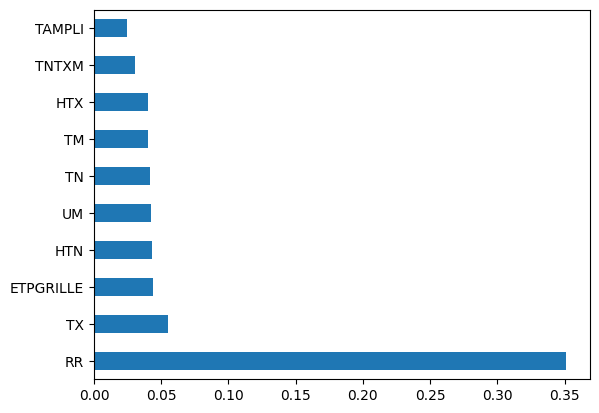

Visualizing correlations...


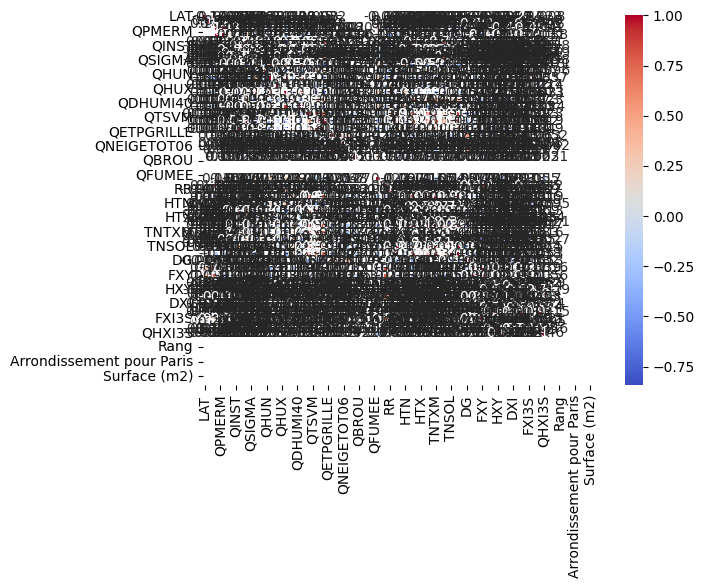

Example prediction with probability for a given station...
Station ID: 75106001
Coordinates: N/A
Prediction: No Probleme
Probabilities: [1. 0.]


In [11]:
# To install shapely, run this command
# !pip install shapely

import pandas as pd
import json
import os
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle  # Import the pickle module
from shapely.geometry import Point, Polygon  # Import shapely for geographical operations

# Function to convert dates with different formats
def parse_dates(date_str):
    try:
        return pd.to_datetime(date_str, format='%d/%m/%Y', errors='raise')
    except ValueError:
        try:
            return pd.to_datetime(date_str, format='%Y-%m-%d', errors='raise')
        except ValueError:
            if isinstance(date_str, str) and 'S' in date_str:
                year = int(date_str[:4])
                semester = int(date_str[-1])
                month = 1 if semester == 1 else 7
                return pd.Timestamp(year=year, month=month, day=1)
            else:
                return pd.NaT

# Function to load JSON data
def load_json(file_path):
    with open(file_path, 'r') as file:
        return json.load(file)

# Function to read large CSV files in smaller chunks
def read_csv_in_chunks(file_path, chunk_size=10000):
    reader = pd.read_csv(file_path, dtype={'1': str, '2': str, '4': str}, chunksize=chunk_size, on_bad_lines='skip')
    chunks = []
    for chunk in reader:
        chunks.append(chunk)
    return pd.concat(chunks, ignore_index=True)

# Function to load all CSV files from a directory
def load_all_csv_from_dir(directory, chunk_size=10000):
    all_data = []
    for file in os.listdir(directory):
        if file.endswith('.csv'):
            print(f"Loading {file}...")
            try:
                data = read_csv_in_chunks(os.path.join(directory, file), chunk_size=chunk_size)
                all_data.append(data)
            except Exception as e:
                print(f"Error loading {file}: {e}")
    return pd.concat(all_data, ignore_index=True)

# Load datasets
print("Loading datasets...")
weather_df = pd.read_csv('./all_weather/2023-2024-weather_cleaned.csv')
traffic_df = pd.read_csv('./freq_arret/2013-2021_trafic.csv')
validations_df = pd.read_csv('./freq_arret/validations-reseau-ferre-nombre-validations-par-jour-1er-semestre.csv', sep=';')
chantier_df = pd.read_csv('./chantier2019-2022.csv')

print("Chargement du JSON des voies ferrées...")
with open(r'C:\Users\SKONIECZNY\Desktop\Transport_App\client\src\common\traces-du-reseau-ferre-idf.json', 'r') as file:
    voie_data = json.load(file)
print("JSON des voies ferrées chargé.")

# Extraire les informations du JSON des voies ferrées
print("Extraction des informations du JSON des voies ferrées...")
voies_list = []
for feature in voie_data['features']:
    properties = feature['properties']
    coordinates = feature['geometry']['coordinates']
    voie = {
        'idrefliga': properties['idrefliga'],
        'reseau': properties['reseau'],
        'mode': properties['mode'],
        'coordinates': coordinates
    }
    voies_list.append(voie)
voies_df = pd.DataFrame(voies_list)
print("Informations des voies ferrées extraites.")

# Function to check if a point is within any of the coordinates in the voie
def is_point_in_voie(lat, lon, voie_coords):
    point = Point(lon, lat)
    for coord_set in voie_coords:
        if isinstance(coord_set[0], list):  # If coord_set is a list of lists (multi-polygon)
            for sub_coords in coord_set:
                if len(sub_coords) > 2:
                    polygon = Polygon(sub_coords)
                    if polygon.contains(point):
                        return True
        elif len(coord_set) > 2:
            polygon = Polygon(coord_set)
            if polygon.contains(point):
                return True
    return False

# Function to find the matching voie for each station
def find_matching_voie(row, voies_df):
    for _, voie in voies_df.iterrows():
        if is_point_in_voie(row['LAT'], row['LON'], voie['coordinates']):
            return voie['reseau'], voie['mode']
    return None, None

# Preprocess data
print("Preprocessing data...")

# Rename columns for easier merging
print("Renaming columns...")
weather_df.rename(columns={'NUM_POSTE': 'station_id', 'AAAAMMJJ': 'date'}, inplace=True)
traffic_df.rename(columns={'Station': 'station_name', 'Trafic': 'traffic'}, inplace=True)
validations_df.rename(columns={'CODE_STIF_ARRET': 'station_id', 'JOUR': 'date'}, inplace=True)
chantier_df.rename(columns={'Date début du chantier': 'start_date', 'Date fin du chantier': 'end_date'}, inplace=True)
print("Columns renamed.")

# Convert 'station_id' to string for the two dataframes before merging
print("Converting data types...")
weather_df['station_id'] = weather_df['station_id'].astype(str)
validations_df['station_id'] = validations_df['station_id'].astype(str)
merged_nb_fer_df['station_id'] = merged_nb_fer_df['CODE_STIF_ARRET'].astype(str)
merged_profil_df['station_id'] = merged_profil_df['CODE_STIF_ARRET'].astype(str)

# Convert dates to datetime format
weather_df['date'] = pd.to_datetime(weather_df['date'], format='%Y%m%d')
validations_df['date'] = pd.to_datetime(validations_df['date'], format='%Y-%m-%d')
chantier_df['start_date'] = pd.to_datetime(chantier_df['start_date'])
chantier_df['end_date'] = pd.to_datetime(chantier_df['end_date'])
merged_nb_fer_df['date'] = merged_nb_fer_df['date'].apply(parse_dates)
merged_profil_df['date'] = merged_profil_df['date'].apply(parse_dates)
print("Data types converted.")

# Merge datasets on stations and dates
print("Merging datasets...")
merged_df = pd.merge(weather_df, validations_df, on=['station_id', 'date'], how='left')
merged_df = pd.merge(merged_df, traffic_df, left_on='station_id', right_on='station_name', how='left')
merged_df = pd.merge(merged_df, merged_nb_fer_df, on=['station_id', 'date'], how='left')
merged_df = pd.merge(merged_df, merged_profil_df, on=['station_id', 'date'], how='left')

# Ensure chantier_df is merged to include 'start_date' and 'end_date'
print("Merging chantier information...")
chantier_df['start_date'] = pd.to_datetime(chantier_df['start_date'])
chantier_df['end_date'] = pd.to_datetime(chantier_df['end_date'])
chantier_df['Code postal arrondissement - Commune'] = chantier_df['Code postal arrondissement - Commune'].astype(str)

merged_df['Code postal arrondissement - Commune'] = merged_df['station_id'].apply(lambda x: x[:5])
merged_df = pd.merge(merged_df, chantier_df, left_on='Code postal arrondissement - Commune', right_on='Code postal arrondissement - Commune', how='left')

# Join line reports (process disruptions to include them in the merged dataframe)
def get_disruption_info(station_id, line_reports):
    for report in line_reports:
        for disruption in report.get('disruptions', []):
            for obj in disruption.get('impacted_objects', []):
                if obj['pt_object']['id'] == station_id:
                    return disruption['category'], disruption['severity']['effect']
    return None, None

print("Adding line report information...")
merged_df[['disruption_category', 'disruption_effect']] = merged_df['station_id'].apply(lambda x: get_disruption_info(x, line_reports)).apply(pd.Series)

# Apply the function to find matching voie
print("Finding matching voie for each station...")
merged_df[['reseau', 'mode']] = merged_df.apply(lambda row: find_matching_voie(row, voies_df), axis=1, result_type="expand")

# Create a binary column to indicate a problem
print("Creating 'probleme' column...")
def has_probleme(row):
    probleme = 0
    if (pd.notnull(row.get('start_date')) and pd.notnull(row.get('end_date')) and row['start_date'] <= row['date'] <= row['end_date']):
        probleme += 1
    if pd.notnull(row.get('NEIG')) and row['NEIG'] > 3:
        probleme += 1
    if pd.notnull(row.get('RR')) and row['RR'] > 20:
        probleme += 1
    if pd.notnull(row.get('traffic')) and row['traffic'] > 200000:
        probleme += 1
    if pd.notnull(row.get('NB_VALD')) and row['NB_VALD'] > 2500:
        probleme += 1
    if pd.notnull(row.get('disruption_category')) or pd.notnull(row.get('disruption_effect')):
        probleme += 1
    return probleme

merged_df['probleme'] = merged_df.apply(has_probleme, axis=1)
print("Colonne 'probleme' créée.")

# Split data into training and testing sets
print("Splitting data into training and testing sets...")
X = merged_df.drop(columns=['probleme'])
y = merged_df['probleme']

# Stratify split to preserve class distribution
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Select numeric and categorical features
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Pipeline for categorical features
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformations in a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Complete pipeline with preprocessing and model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Apply StratifiedKFold on the training set
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Training and evaluating the model with Stratified K-Fold Cross-Validation...")
cross_val_scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy')
print(f"Cross-Validation Accuracy Scores: {cross_val_scores}")
print(f"Mean Cross-Validation Accuracy: {np.mean(cross_val_scores)}")

# Train the model on the training set
print("Training the model on the training set...")
model.fit(X_train, y_train)
print("Model trained.")

# Evaluate the model on the test set
print("Evaluating the model on the test set...")
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")

# Save the model using pickle
with open('issue_prev_voies.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)
print("Model saved as 'issue_prev_voies.pkl'.")
# Save merged_df to CSV
merged_df.to_csv('merged_df_voies.csv', index=False)
print("merged_df saved to 'merged_df_voies.csv'.")

# Visualize results
print("Visualizing results...")
# Extract feature importances
importances = model.named_steps['classifier'].feature_importances_

# Get feature names after OneHotEncoding
encoder = model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder']
encoded_cat_features = encoder.get_feature_names_out(categorical_features)

# Combine feature names
feature_names = np.hstack([numeric_features, encoded_cat_features])

# Visualize feature importances
feature_importances = pd.Series(importances, index=feature_names)
feature_importances.nlargest(10).plot(kind='barh')
plt.show()

# Heatmap of correlations
print("Visualizing correlations...")
numeric_df = merged_df[numeric_features]
corr_matrix = numeric_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()



print("Example prediction with probability for a given station...")
example_station_id = merged_df.iloc[0]['station_id']
example_row = merged_df[merged_df['station_id'] == example_station_id].drop(columns=['probleme']).iloc[0].to_frame().T
example_prediction = model.predict(example_row)[0]
example_proba = model.predict_proba(example_row)[0]

print(f"Station ID: {example_station_id}")
print(f"Coordinates: {merged_df[merged_df['station_id'] == example_station_id]['coordinates'].values[0] if 'coordinates' in merged_df.columns else 'N/A'}")
print(f"Prediction: {'Probleme' if example_prediction == 1 else 'No Probleme'}")
print(f"Probabilities: {example_proba}")


In [12]:
df_merged_voies = pd.read_csv('merged_df_voies.csv')
df_merged_voies

,station_id,NOM_USUEL,LAT,LON,ALTI_x,date,PMERM,QPMERM,PMERMIN,QPMERMIN,...,Impact stationnement,Identifiant demande CITE,Identifiant Chantier CITE,geo_shape,geo_point_2d,disruption_category,disruption_effect,reseau,mode,probleme
0,75106001,LUXEMBOURG,48.844667,2.333833,46.0,2023-01-01,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,75107005,TOUR EIFFEL,48.858333,2.294500,330.0,2023-01-01,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,75110001,LARIBOISIERE,48.882833,2.352000,55.0,2023-01-01,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,75112004,ST-ANTOINE,48.848167,2.380833,NaN,2023-01-01,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,75114001,PARIS-MONTSOURIS,48.821667,2.337833,75.0,2023-01-01,1014.9,1.0,1012.2,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2961,75107005,TOUR EIFFEL,48.858333,2.294500,330.0,2024-04-28,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2962,75110001,LARIBOISIERE,48.882833,2.352000,55.0,2024-04-28,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2963,75114001,PARIS-MONTSOURIS,48.821667,2.337833,75.0,2024-04-28,1010.8,1.0,1001.4,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2964,75114007,PARIS-MONTSOURIS-DOUBLE,48.821667,2.337833,75.0,2024-04-28,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


Loading datasets...
Loading railways JSON...
Railways JSON loaded.
Extracting railway information from JSON...
Railway information extracted.
Preprocessing data...
Renaming columns...
Columns renamed.
Converting data types...
Data types converted.
Merging datasets...
Merging chantier information...
Finding matching voie for each station...
Creating 'probleme' column...
Colonne 'probleme' créée.
     station_id                NOM_USUEL        LAT       LON  ALTI_x  \
0      75106001               LUXEMBOURG  48.844667  2.333833    46.0   
1      75107005              TOUR EIFFEL  48.858333  2.294500   330.0   
2      75110001             LARIBOISIERE  48.882833  2.352000    55.0   
3      75112004               ST-ANTOINE  48.848167  2.380833     NaN   
4      75114001         PARIS-MONTSOURIS  48.821667  2.337833    75.0   
...         ...                      ...        ...       ...     ...   
2961   75107005              TOUR EIFFEL  48.858333  2.294500   330.0   
2962   75110001   

c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\SKONIECZNY\anaconda

Cross-Validation Accuracy Scores: [0.99368421 0.99157895 0.99367089 0.99367089 0.99156118]
Mean Cross-Validation Accuracy: 0.9928332222962469
Training the model on the training set...


c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Model trained.
Evaluating the model on the test set...
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       589
           1       0.00      0.00      0.00         5

    accuracy                           0.99       594
   macro avg       0.50      0.50      0.50       594
weighted avg       0.98      0.99      0.99       594

Test Accuracy: 0.9915824915824916
Model saved as 'issue_prev_voies.pkl'.
merged_df saved to 'merged_df_voies.csv'.
Visualizing results...


c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

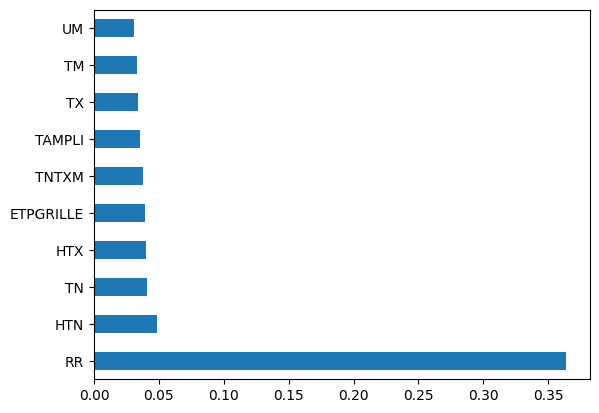

Visualizing correlations...


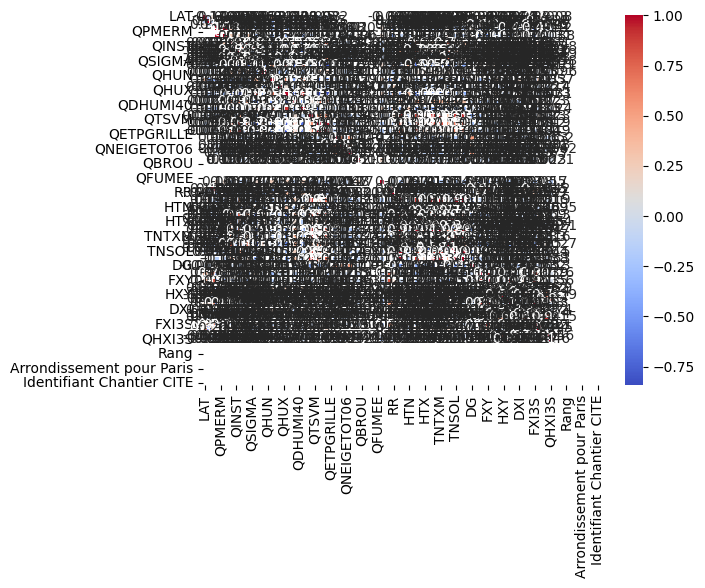

Example prediction with probability for a given station...
Station ID: 75106001
Coordinates: N/A
Prediction: No Probleme
Probabilities: [1. 0.]


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [15]:
import pandas as pd
import json
import os
from shapely.geometry import Point, Polygon
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle

# Function to load JSON data
def load_json(file_path):
    with open(file_path, 'r') as file:
        return json.load(file)

# Function to read large CSV files in smaller chunks
def read_csv_in_chunks(file_path, chunk_size=10000):
    reader = pd.read_csv(file_path, chunksize=chunk_size, on_bad_lines='skip')
    chunks = []
    for chunk in reader:
        chunks.append(chunk)
    return pd.concat(chunks, ignore_index=True)

# Load datasets
print("Loading datasets...")
weather_df = pd.read_csv('./all_weather/2023-2024-weather_cleaned.csv')
traffic_df = pd.read_csv('./freq_arret/2013-2021_trafic.csv')
validations_df = pd.read_csv('./freq_arret/validations-reseau-ferre-nombre-validations-par-jour-1er-semestre.csv', sep=';')
chantier_df = pd.read_csv('./chantier2019-2022.csv')

print("Loading railways JSON...")
voie_data = load_json('./traces-du-reseau-ferre-idf.json')
print("Railways JSON loaded.")

# Extract railway information from JSON
print("Extracting railway information from JSON...")
voies_list = []
for feature in voie_data['features']:
    properties = feature['properties']
    coordinates = feature['geometry']['coordinates']
    voie = {
        'idrefliga': properties['idrefliga'],
        'reseau': properties['reseau'],
        'mode': properties['mode'],
        'coordinates': coordinates
    }
    voies_list.append(voie)
voies_df = pd.DataFrame(voies_list)
print("Railway information extracted.")

# Function to check if a point is within any of the coordinates in the voie
def is_point_in_voie(lat, lon, voie_coords):
    point = Point(lon, lat)
    for coord_set in voie_coords:
        if isinstance(coord_set[0], list):  # If coord_set is a list of lists (multi-polygon)
            for sub_coords in coord_set:
                if len(sub_coords) > 2:
                    polygon = Polygon(sub_coords)
                    if polygon.contains(point):
                        return True
        elif len(coord_set) > 2:
            polygon = Polygon(coord_set)
            if polygon.contains(point):
                return True
    return False

# Function to find the matching voie for each station
def find_matching_voie(row, voies_df):
    for _, voie in voies_df.iterrows():
        if is_point_in_voie(row['LAT'], row['LON'], voie['coordinates']):
            return voie['reseau'], voie['mode']
    return None, None

# Preprocess data
print("Preprocessing data...")

# Rename columns for easier merging
print("Renaming columns...")
weather_df.rename(columns={'NUM_POSTE': 'station_id', 'AAAAMMJJ': 'date'}, inplace=True)
traffic_df.rename(columns={'Station': 'station_name', 'Trafic': 'traffic'}, inplace=True)
validations_df.rename(columns={'CODE_STIF_ARRET': 'station_id', 'JOUR': 'date'}, inplace=True)
chantier_df.rename(columns={'Date début du chantier': 'start_date', 'Date fin du chantier': 'end_date'}, inplace=True)
print("Columns renamed.")

# Convert 'station_id' to string for the two dataframes before merging
print("Converting data types...")
weather_df['station_id'] = weather_df['station_id'].astype(str)
validations_df['station_id'] = validations_df['station_id'].astype(str)
traffic_df['station_name'] = traffic_df['station_name'].astype(str)
chantier_df['Code postal arrondissement - Commune'] = chantier_df['Code postal arrondissement - Commune'].astype(str)

# Convert dates to datetime format
weather_df['date'] = pd.to_datetime(weather_df['date'], format='%Y%m%d')
validations_df['date'] = pd.to_datetime(validations_df['date'], format='%Y-%m-%d')
chantier_df['start_date'] = pd.to_datetime(chantier_df['start_date'])
chantier_df['end_date'] = pd.to_datetime(chantier_df['end_date'])
print("Data types converted.")

# Merge datasets on stations and dates
print("Merging datasets...")
merged_df = pd.merge(weather_df, validations_df, on=['station_id', 'date'], how='left')
merged_df = pd.merge(merged_df, traffic_df, left_on='station_id', right_on='station_name', how='left')

# Ensure chantier_df is merged to include 'start_date' and 'end_date'
print("Merging chantier information...")
merged_df['Code postal arrondissement - Commune'] = merged_df['station_id'].str[:5]
merged_df = pd.merge(merged_df, chantier_df, left_on='Code postal arrondissement - Commune', right_on='Code postal arrondissement - Commune', how='left')

# Apply the function to find matching voie
print("Finding matching voie for each station...")
merged_df[['reseau', 'mode']] = merged_df.apply(lambda row: find_matching_voie(row, voies_df), axis=1, result_type="expand")

# Create a binary column to indicate a problem
print("Creating 'probleme' column...")
def has_probleme(row):
    probleme = 0
    if (pd.notnull(row.get('start_date')) and pd.notnull(row.get('end_date')) and row['start_date'] <= row['date'] <= row['end_date']):
        probleme += 1
    if pd.notnull(row.get('NEIG')) and row['NEIG'] > 3:
        probleme += 1
    if pd.notnull(row.get('RR')) and row['RR'] > 20:
        probleme += 1
    if pd.notnull(row.get('traffic')) and row['traffic'] > 200000:
        probleme += 1
    if pd.notnull(row.get('NB_VALD')) and row['NB_VALD'] > 2500:
        probleme += 1
    if pd.notnull(row.get('disruption_category')) or pd.notnull(row.get('disruption_effect')):
        probleme += 1
    return probleme

merged_df['probleme'] = merged_df.apply(has_probleme, axis=1)
print("Colonne 'probleme' créée.")
print(merged_df)

# Split data into training and testing sets
print("Splitting data into training and testing sets...")
X = merged_df.drop(columns=['probleme'])
y = merged_df['probleme']

# Stratify split to preserve class distribution
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Select numeric and categorical features
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Pipeline for categorical features
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformations in a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Complete pipeline with preprocessing and model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Apply StratifiedKFold on the training set
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Training and evaluating the model with Stratified K-Fold Cross-Validation...")
cross_val_scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy')
print(f"Cross-Validation Accuracy Scores: {cross_val_scores}")
print(f"Mean Cross-Validation Accuracy: {np.mean(cross_val_scores)}")

# Train the model on the training set
print("Training the model on the training set...")
model.fit(X_train, y_train)
print("Model trained.")

# Evaluate the model on the test set
print("Evaluating the model on the test set...")
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")

# Save the model using pickle
with open('issue_prev_voies.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)
print("Model saved as 'issue_prev_voies.pkl'.")

# Save merged_df to CSV
merged_df.to_csv('merged_df_voies.csv', index=False)
print("merged_df saved to 'merged_df_voies.csv'.")


In [16]:
# Function to predict problem for given reseau
def predict_probleme_for_reseau(reseau):
    input_data = {
        'reseau': reseau,
    }
    for col in numeric_features:
        input_data[col] = [0]  # Fill other features with default values
    input_df = pd.DataFrame(input_data)
    input_df = input_df.reindex(columns=X_train.columns, fill_value=0)
    
    prediction = model.predict(input_df)[0]
    proba = model.predict_proba(input_df)[0]
    
    return prediction, proba

# Example usage
reseau_to_predict = 'RER E'
prediction, proba = predict_probleme_for_reseau(reseau_to_predict)
print(f"Prediction for {reseau_to_predict}: {'Probleme' if prediction == 1 else 'No Probleme'}")
print(f"Probabilities: {proba}")

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [18]:
df_merged_voies = pd.read_csv("merged_df_voies.csv")
df_merged_voies

,station_id,NOM_USUEL,LAT,LON,ALTI_x,date,PMERM,QPMERM,PMERMIN,QPMERMIN,...,Synthèse - Nature du chantier,Encombrement espace public,Impact stationnement,Identifiant demande CITE,Identifiant Chantier CITE,geo_shape,geo_point_2d,reseau,mode,probleme
0,75106001,LUXEMBOURG,48.844667,2.333833,46.0,2023-01-01,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,75107005,TOUR EIFFEL,48.858333,2.294500,330.0,2023-01-01,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,75110001,LARIBOISIERE,48.882833,2.352000,55.0,2023-01-01,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,75112004,ST-ANTOINE,48.848167,2.380833,NaN,2023-01-01,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,75114001,PARIS-MONTSOURIS,48.821667,2.337833,75.0,2023-01-01,1014.9,1.0,1012.2,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2961,75107005,TOUR EIFFEL,48.858333,2.294500,330.0,2024-04-28,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2962,75110001,LARIBOISIERE,48.882833,2.352000,55.0,2024-04-28,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2963,75114001,PARIS-MONTSOURIS,48.821667,2.337833,75.0,2024-04-28,1010.8,1.0,1001.4,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2964,75114007,PARIS-MONTSOURIS-DOUBLE,48.821667,2.337833,75.0,2024-04-28,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
